In [ ]:
!pip install --upgrade pip
!pip install pymc arviz numpy scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install ucimlrepo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import pymc as pm
#import aesara
#import aesara.tensor as at
from sklearn.metrics import accuracy_score, log_loss, f1_score

import numpy as np
from sklearn.base import clone
from scipy.stats import norm, gaussian_kde
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import clone
import numpy as np
from sklearn.base import clone
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import BaseEstimator, ClassifierMixin, clone


class EstimatorWithCoef(BaseEstimator, ClassifierMixin):
    """
    Wraps a Bayesian logistic estimator so that after fit() it exposes:
      - coef_  (pulls from coef_ if present, else from coef_mean_)
      - predict / predict_proba / score delegated to the inner model
    This makes it compatible with sklearn RFE.
    """
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator
        self.model_ = None
        self.coef_ = None

    def get_params(self, deep=True):
        # So GridSearchCV/clone works
        return {"base_estimator": self.base_estimator}

    def set_params(self, **params):
        if "base_estimator" in params:
            self.base_estimator = params["base_estimator"]
        return self

    def fit(self, X, y):
        self.model_ = clone(self.base_estimator).fit(X, y)
        if hasattr(self.model_, "coef_"):
            self.coef_ = getattr(self.model_, "coef_")
        elif hasattr(self.model_, "coef_mean_"):
            self.coef_ = getattr(self.model_, "coef_mean_")
        else:
            raise AttributeError("Wrapped estimator must expose coef_ or coef_mean_ after fit().")
        # Flatten shapes like (1,p)
        self.coef_ = getattr(self.coef_, "ravel", lambda: self.coef_)()
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def score(self, X, y):
        # default classifier score = accuracy
        return self.model_.score(X, y)


from mlxtend.feature_selection import SequentialFeatureSelector as MLX_SFS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.base import clone
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.base import clone
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Custom scorer

macro_f1 = make_scorer(f1_score, average="macro")


from sklearn.model_selection import StratifiedShuffleSplit

def rfe_select_features(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator', LogisticRegression(solver='liblinear'))

    if 'k' in kwargs:
        k = kwargs['k']
        rfe = RFE(estimator, n_features_to_select=k)
        rfe.fit(X_train, y_train)
        selected = np.where(rfe.support_)[0]
        return selected, None

    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        n_splits = kwargs.get('n_splits', 2)
        test_size = kwargs.get('test_size', 0.2)
        random_state = kwargs.get('random_state', 42)

        cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

        best_score = -np.inf
        best_k = 1
        no_improve_counter = 0
        patience = 3

        for k in range(min_k, max_k + 1, 5):
            rfe = RFE(estimator, n_features_to_select=k)
            X_trans = rfe.fit_transform(X_train, y_train)
            score = np.mean(cross_val_score(clone(estimator), X_trans, y_train, cv=cv, scoring=macro_f1, n_jobs=-1))

            if score > best_score:
                best_score = score
                best_k = k
                no_improve_counter = 0
            else:
                no_improve_counter += 1
                if no_improve_counter >= patience:
                    break

        rfe = RFE(estimator, n_features_to_select=best_k)
        rfe.fit(X_train, y_train)
        selected = np.where(rfe.support_)[0]
        return selected, None

def _get_cv_splitter(cv, X, y):
    if isinstance(cv, int):
        return StratifiedShuffleSplit(n_splits=cv, test_size=0.2, random_state=42)
    return cv

def sfs_select_features(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        sfs = MLX_SFS(clone(estimator),
                      k_features=k,
                      forward=True,
                      floating=False,
                      scoring=macro_f1,
                      cv=cv_folds,
                      n_jobs=-1)
        sfs.fit(X_train, y_train)
        selected = np.array(sfs.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None
        no_improve_counter = 0
        patience = 3

        for k in range(min_k, max_k + 1, 5):
            sfs = MLX_SFS(clone(estimator),
                          k_features=k,
                          forward=True,
                          floating=False,
                          scoring=macro_f1,
                          cv=cv_folds,
                          n_jobs=-1)
            sfs.fit(X_train, y_train)
            if sfs.k_score_ > best_score:
                best_score = sfs.k_score_
                best_support = sfs.k_feature_idx_
                no_improve_counter = 0
            else:
                no_improve_counter += 1
                if no_improve_counter >= patience:
                    break

        selected = np.array(best_support)
        return selected, None

def sbs_select_features(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        sbs = MLX_SFS(clone(estimator),
                      k_features=k,
                      forward=False,
                      floating=False,
                      scoring=macro_f1,
                      cv=cv_folds,
                      n_jobs=-1)
        sbs.fit(X_train, y_train)
        selected = np.array(sbs.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None
        no_improve_counter = 0
        patience = 3

        #for k in range(min_k, max_k + 1, 5):
        for k in reversed(range(min_k, max_k + 1, 5)):
            sbs = MLX_SFS(clone(estimator),
                          k_features=k,
                          forward=False,
                          floating=False,
                          scoring=macro_f1,
                          cv=cv_folds,
                          n_jobs=-1)
            sbs.fit(X_train, y_train)
            if sbs.k_score_ > best_score:
                best_score = sbs.k_score_
                best_support = sbs.k_feature_idx_
                no_improve_counter = 0
            else:
                no_improve_counter += 1
                if no_improve_counter >= patience:
                    break

        selected = np.array(best_support)
        return selected, None

def bidir_select_features(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        bidi = MLX_SFS(clone(estimator),
                       k_features=k,
                       forward=True,
                       floating=True,
                       scoring=macro_f1,
                       cv=cv_folds,
                       n_jobs=-1)
        bidi.fit(X_train, y_train)
        selected = np.array(bidi.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None
        no_improve_counter = 0
        patience = 3

        for k in range(min_k, max_k + 1, 5):
            bidi = MLX_SFS(clone(estimator),
                           k_features=k,
                           forward=True,
                           floating=True,
                           scoring=macro_f1,
                           cv=cv_folds,
                           n_jobs=-1)
            bidi.fit(X_train, y_train)
            if bidi.k_score_ > best_score:
                best_score = bidi.k_score_
                best_support = bidi.k_feature_idx_
                no_improve_counter = 0
            else:
                no_improve_counter += 1
                if no_improve_counter >= patience:
                    break

        selected = np.array(best_support)
        return selected, None


def rfe_select_features_old(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator', LogisticRegression(solver='liblinear'))

    if 'k' in kwargs:
        k = kwargs['k']
        rfe = RFE(estimator, n_features_to_select=k)
        rfe.fit(X_train, y_train)
        selected = np.where(rfe.support_)[0]
        return selected, None

    else:
        max_k = kwargs.get('max_k', X_train.shape[1])
        n_splits = kwargs.get('n_splits', 2)
        test_size = kwargs.get('test_size', 0.2)
        random_state = kwargs.get('random_state', 42)

        cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

        best_score = -np.inf
        best_k = 1

        for k in range(1, max_k + 1, 5):
            rfe = RFE(estimator, n_features_to_select=k)
            X_trans = rfe.fit_transform(X_train, y_train)
            score = np.mean(cross_val_score(clone(estimator), X_trans, y_train, cv=cv, scoring=macro_f1, n_jobs=-1))

            if score > best_score:
                best_score = score
                best_k = k

        # Final fit with best_k
        rfe = RFE(estimator, n_features_to_select=best_k)
        rfe.fit(X_train, y_train)
        selected = np.where(rfe.support_)[0]
        return selected, None


def _get_cv_splitter(cv, X, y):
    if isinstance(cv, int):
        return StratifiedShuffleSplit(n_splits=cv, test_size=0.2, random_state=42)
    return cv


def sfs_select_features_old(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        sfs = MLX_SFS(clone(estimator),
                      k_features=k,
                      forward=True,
                      floating=False,
                      scoring=macro_f1,
                      cv=cv_folds,
                      n_jobs=-1)
        sfs.fit(X_train, y_train)
        selected = np.array(sfs.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None

        for k in range(min_k, max_k + 1, 5):
            sfs = MLX_SFS(clone(estimator),
                          k_features=k,
                          forward=True,
                          floating=False,
                          scoring=macro_f1,
                          cv=cv_folds,
                          n_jobs=-1)
            sfs.fit(X_train, y_train)
            if sfs.k_score_ > best_score:
                best_score = sfs.k_score_
                best_support = sfs.k_feature_idx_

        selected = np.array(best_support)
        return selected, None


def sbs_select_features_old(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        sbs = MLX_SFS(clone(estimator),
                      k_features=k,
                      forward=False,
                      floating=False,
                      scoring=macro_f1,
                      cv=cv_folds,
                      n_jobs=-1)
        sbs.fit(X_train, y_train)
        selected = np.array(sbs.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None

        for k in range(min_k, max_k + 1, 5):
            sbs = MLX_SFS(clone(estimator),
                          k_features=k,
                          forward=False,
                          floating=False,
                          scoring=macro_f1,
                          cv=cv_folds,
                          n_jobs=-1)
            sbs.fit(X_train, y_train)
            if sbs.k_score_ > best_score:
                best_score = sbs.k_score_
                best_support = sbs.k_feature_idx_

        selected = np.array(best_support)
        return selected, None


def bidir_select_features_old(X_train, y_train, **kwargs):
    estimator = kwargs.get('estimator')
    cv_folds = _get_cv_splitter(kwargs.get('cv', 2), X_train, y_train)

    if 'k' in kwargs:
        k = kwargs['k']
        bidi = MLX_SFS(clone(estimator),
                       k_features=k,
                       forward=True,
                       floating=True,
                       scoring=macro_f1,
                       cv=cv_folds,
                       n_jobs=-1)
        bidi.fit(X_train, y_train)
        selected = np.array(bidi.k_feature_idx_)
        return selected, None
    else:
        min_k = kwargs.get('min_k', 1)
        max_k = kwargs.get('max_k', X_train.shape[1])
        best_score = -np.inf
        best_support = None

        for k in range(min_k, max_k + 1, 5):
            bidi = MLX_SFS(clone(estimator),
                           k_features=k,
                           forward=True,
                           floating=True,
                           scoring=macro_f1,
                           cv=cv_folds,
                           n_jobs=-1)
            bidi.fit(X_train, y_train)
            if bidi.k_score_ > best_score:
                best_score = bidi.k_score_
                best_support = bidi.k_feature_idx_

        selected = np.array(best_support)
        return selected, None



def _to_index_or_mask(selected_idx, n_features):
    """
    Normalize selector output into either:
      - an integer index array (dtype=int), or
      - a boolean mask of length n_features.
    """
    # None or empty -> keep all
    if selected_idx is None:
        return np.arange(n_features, dtype=int)
    # convert sets/tuples/lists to np array
    arr = np.asarray(list(selected_idx) if isinstance(selected_idx, set) else selected_idx)

    # boolean mask?
    if arr.dtype == bool:
        if arr.ndim != 1 or arr.shape[0] != n_features:
            raise ValueError("Boolean mask has wrong shape.")
        return arr  # mask

    # tuple from mlxtend (k_feature_idx_) can be tuple of ints
    # also handle nested tuples/lists (e.g. ((1,3,4,5,8),))
    if arr.ndim > 1:
        arr = np.ravel(arr)

    # cast to int safely
    try:
        idx = arr.astype(int)
    except Exception:
        # last resort: map each entry to int explicitly
        idx = np.array([int(x) for x in arr])

    # guard for NaNs or negatives
    if np.any(idx < 0) or np.any(idx >= n_features):
        raise IndexError(f"Selected indices out of bounds for n_features={n_features}: {idx}")
    return idx


def evaluate_feature_selection_method_cls(feature_selector,
                                          X_train, y_train,
                                          X_test, y_test,
                                          selector_params={},
                                          model_params={},
                                          eval_indices_bs=None):
    """
    Evaluate feature selection for classification using Bayesian models.

    - Selects features on Train
    - Fits Bayesian model on Train-selected features
    - Reports Accuracy, Macro-F1, Log-loss on Test
    - Computes Sign Entropy from posterior (mu, sigma) of Train-fitted model
    """

    #selector_params = selector_params.copy()  # avoid mutating original
    est = clone(selector_params['evaluator'])
    est_test = clone(selector_params['evaluator'])

    evaluator = selector_params.pop('evaluator', None)

    # run feature selector
    selected_idx, _ = feature_selector(X_train, y_train, **selector_params)

    # normalize selection
    n_features = X_train.shape[1]
    sel = _to_index_or_mask(selected_idx, n_features)

    # slice data
    if isinstance(sel, np.ndarray) and sel.dtype == bool:
        X_tr, X_te = X_train[:, sel], X_test[:, sel]
        kept_idx = np.where(sel)[0]
    else:
        X_tr, X_te = X_train[:, sel], X_test[:, sel]
        kept_idx = np.asarray(sel, dtype=int)

    # fit estimator on Train
    #est = clone(selector_params['evaluator']).fit(X_tr, y_train)
    est.fit(X_tr, y_train)

    # predictions on Test
    if hasattr(est, "predict_proba"):
        proba = est.predict_proba(X_te)
        if proba.ndim == 1 or proba.shape[1] == 1:
            p1 = np.ravel(proba); proba = np.c_[1 - p1, p1]
        y_pred = (proba[:, 1] >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average="macro")
        ll  = log_loss(y_test, proba)
    else:
        y_pred = est.predict(X_te)
        acc = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average="macro")
        ll  = None

    # stability: sign entropy from posterior (mu, sigma) in test
    #est_test = clone(selector_params['evaluator']).fit(X_te, y_te)
    est_test.fit(X_te, y_te)

    entropies = None
    if hasattr(est_test, "coef_") and hasattr(est_test, "sigma_"):
        # Bayesian evaluator: direct posterior mean + std
        entropies = calculate_entropy_dist(est_test.coef_, est_test.sigma_)
    else:
        # Frequentist evaluator: bootstrap 1000 fits on the *test set*
        n_bootstraps = 1000
        coefs = []

        rng = np.random.RandomState(42)
        for _ in range(n_bootstraps):
            # stratified bootstrap indices
            classes, counts = np.unique(y_te, return_counts=True)
            idxs = []
            for c, cnt in zip(classes, counts):
                cls_idx = np.where(y_te == c)[0]
                take = rng.choice(cls_idx, size=cnt, replace=True)
                idxs.append(take)
            idxs = np.concatenate(idxs)
            rng.shuffle(idxs)

            X_bs, y_bs = X_te[idxs], y_te[idxs]
            if len(np.unique(y_bs)) < 2:
                continue  # skip if only one class

            try:
                clf_bs = clone(evaluator).fit(X_bs, y_bs)
                coefs.append(np.ravel(clf_bs.coef_))
            except Exception:
                continue

        if len(coefs) < 10:
            # too few successes -> signal with NaNs
            entropies = np.full(X_te.shape[1], np.nan)
        else:
            coef_mat = np.vstack(coefs)        # shape: (n_bootstraps, p)
            entropies = calculate_entropies(coef_mat)  # your KDE-based fn

        entropies = np.atleast_1d(np.asarray(entropies, dtype=float))

    return kept_idx, {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "log_loss": ll,
        "sign_entropy": entropies,
        "mean_entropy": np.mean(entropies) if entropies is not None else None
    }


# --- helpers ---
def calculate_entropy(data):
    if np.var(data) == 0:
        return 0

    scipy_kernel = gaussian_kde(data)

    #  We calculate the bandwidth for later use
    optimal_bandwidth = scipy_kernel.factor * np.std(data)

    # Calculate KDE for the entire dataset
    kde = gaussian_kde(data, bw_method=optimal_bandwidth)

    # Create a range of values to represent the KDE
    x = np.linspace(np.min(data), np.max(data), 1000)

    # Evaluate the density at each point in the range
    density = kde(x)

    # Normalize the density function
    normalized_density = density / np.sum(density * (x[1] - x[0]))

    # Calculate the probabilities of positive and negative values
    positive_probability = np.sum(normalized_density[x >= 0] * (x[1] - x[0]))
    negative_probability = np.sum(normalized_density[x < 0] * (x[1] - x[0]))

    if positive_probability == 0 or negative_probability == 0:
        sign_entropy = 0
    else:
        sign_entropy = -positive_probability * np.log2(positive_probability) \
                       - negative_probability * np.log2(negative_probability)

    return sign_entropy


def calculate_entropies(result_matrix):
    sign_entropies = []
    for column in range(result_matrix.shape[1]):
        data = result_matrix[:, column]
        sign_entropy = calculate_entropy(data)
        sign_entropies.append(sign_entropy)

    sign_entropies = np.array(sign_entropies)

    return sign_entropies


def _entropy_from_samples(beta_samples):
    # beta_samples: (draws, p) posterior samples (no intercept)
    p_pos = (beta_samples > 0).mean(axis=0)
    p_pos = np.clip(p_pos, 1e-12, 1 - 1e-12)  # avoid log(0)
    p_neg = 1.0 - p_pos
    return -(p_pos * np.log2(p_pos) + p_neg * np.log2(p_neg))


def _entropy_from_gaussian(mu, Sigma, has_intercept=False):
    # mu: (p,) or (p+1,) ; Sigma: (p,p) or (p+1,p+1) or diag vector
    mu = np.ravel(mu)
    if Sigma.ndim == 2:
        diag_vars = np.diag(Sigma)
    else:
        diag_vars = np.ravel(Sigma)
    if has_intercept:
        mu = mu[1:]
        diag_vars = diag_vars[1:]
    sigma = np.sqrt(np.clip(diag_vars, 1e-12, None))
    p_neg = norm.cdf(0.0, loc=mu, scale=sigma)
    p_pos = 1.0 - p_neg
    H = np.zeros_like(mu, dtype=float)
    mid = (p_pos > 0) & (p_pos < 1)
    H[mid] = -(p_pos[mid]*np.log2(p_pos[mid]) + p_neg[mid]*np.log2(p_neg[mid]))
    return H


# ---------- utilities ----------
def calculate_entropy_from_samples(beta_samples):
    """
    beta_samples: array (n_draws, p) of posterior draws for coefficients (no intercept).
    Return: entropy per feature (p,), using base-2 logs.
    """
    p_pos = (beta_samples > 0).mean(axis=0)
    p_pos = np.clip(p_pos, 1e-12, 1 - 1e-12)  # numerical safety at boundaries
    p_neg = 1.0 - p_pos
    H = -(p_pos * np.log2(p_pos) + p_neg * np.log2(p_neg))
    return H

# ---------- Bayesian logistic classifier (PyMC, ADVI for speed) ----------


class BayesianLogisticPyMC(BaseEstimator, ClassifierMixin):
    """
    Bayesian logistic regression with Normal(0, prior_std) priors on weights.
    NOTE: 'prior_std' is a STANDARD DEVIATION, not a precision.
    """

    def __init__(self, prior_std=1.0, prior_type="normal", fit_intercept=True,
                 advi_iters=20000, draws=2000, random_state=0, verbose=False,
                 penalize_intercept=False, intercept_std=10.0,  # if True, Normal(0, intercept_std); else Flat
                 fullrank=False):
        self.prior_std = float(prior_std)
        self.fit_intercept = bool(fit_intercept)
        self.advi_iters = int(advi_iters)
        self.draws = int(draws)
        self.random_state = int(random_state)
        self.verbose = bool(verbose)
        self.penalize_intercept = bool(penalize_intercept)
        self.intercept_std = float(intercept_std)
        self.fullrank = bool(fullrank)
        self.prior_type = prior_type

        self.coef_samples_ = None
        self.intercept_samples_ = None
        self.coef_mean_ = None
        self.Sigma_ = None
        self.coef_ = None
        self.sigma_ = None  # per-feature posterior std

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=int).ravel()
        if set(np.unique(y)) - {0, 1}:
            raise ValueError("Binary labels {0,1} required.")
        n, p = X.shape

        elbo_vals = []

        def track_elbo(approx, n, elbo):
            elbo_vals.append(elbo)


        with pm.Model() as model:
            # multiple priors
            if self.prior_type == "gaussian":
                beta = pm.Normal("beta", mu=0.0, sigma=self.prior_std, shape=p)
            elif self.prior_type == "laplace":
                beta = pm.Laplace("beta", mu=0.0, b=self.prior_std, shape=p)
            elif self.prior_type == "studentt":
                beta = pm.StudentT("beta", nu=3, mu=0.0, sigma=self.prior_std, shape=p)
            elif self.prior_type == "cauchy":
                beta = pm.Cauchy("beta", alpha=0.0, beta=self.prior_std, shape=p)
            else:
                raise ValueError(f"Unsupported prior_type: {self.prior_type}")
            # multiple priors

            #beta = pm.Normal("beta", mu=0.0, sigma=self.prior_std, shape=p)

            if self.fit_intercept:
                if self.penalize_intercept:
                    alpha = pm.Normal("alpha", mu=0.0, sigma=self.intercept_std)
                else:
                    alpha = pm.Flat("alpha")  # unpenalized intercept, like sklearn
                eta = alpha + pm.math.dot(X, beta)
            else:
                eta = pm.math.dot(X, beta)

            pm.Bernoulli("y", p=pm.math.sigmoid(eta), observed=y)

            method = "fullrank_advi" if self.fullrank else "advi"
            approx = pm.fit(self.advi_iters, method=method,
                            random_seed=self.random_state, progressbar=self.verbose,
                            callbacks=[track_elbo])
            self.elbo_vals_ = np.array(elbo_vals)
            self.idata_ = approx.sample(self.draws, random_seed=self.random_state)
            #idata = approx.sample(self.draws, random_seed=self.random_state)

        # Extract posterior draws
        beta_draws = np.asarray(self.idata_.posterior["beta"]).reshape(-1, p)
        self.coef_samples_ = beta_draws
        if self.fit_intercept:
            self.intercept_samples_ = np.asarray(self.idata_.posterior["alpha"]).reshape(-1)

        # Summaries
        # Posterior summaries (robust to p==1)
        self.coef_mean_ = beta_draws.mean(axis=0)
        self.sigma_     = beta_draws.std(axis=0, ddof=1)
        p = beta_draws.shape[1]
        if p > 1:
            self.Sigma_ = np.cov(beta_draws.T, ddof=1)
        else:
            var = float(self.sigma_[0] ** 2)
            self.Sigma_ = np.array([[var]])
        self.coef_ = self.coef_mean_

        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        eta = X @ self.coef_samples_.T
        if self.fit_intercept and self.intercept_samples_ is not None:
            eta = eta + self.intercept_samples_[None, :]
        p1 = 1.0 / (1.0 + np.exp(-eta))
        p1_mean = p1.mean(axis=1)
        return np.column_stack([1.0 - p1_mean, p1_mean])

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)


# ---------- Bay-CoFE selector for classification ----------

from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
import numpy as np

def sefe_select_features(X_train, y_train, **kwargs):
    """
    SEFE for classification using sklearn LogisticRegression and bootstrapped sign entropy:
    Iteratively fit a logistic regression estimator and drop features
    whose sign entropy > slack, estimated via KDE on bootstrapped coefs.

    kwargs:
      slack (float)     : entropy threshold (default 0.001)
      num_iter (int)    : max elimination passes (default 10)
      tolerance_limit   : stop if no removals for this many consecutive passes (default 1)
      n_bootstraps      : number of bootstraps for sign entropy estimation (default 1000)

    returns:
      np.ndarray of kept feature indices (0-based)
    """
    slack = float(kwargs.get('slack', 0.01))
    num_iter = int(kwargs.get('num_iter', 10))
    tolerance_limit = int(kwargs.get('tolerance_limit', 3))
    n_bootstraps = int(kwargs.get('n_bootstraps', 1000))

    base_estimator = kwargs.get('estimator')

    p = X_train.shape[1]
    drop_mask = np.zeros(p, dtype=bool)
    patience = 0

    for _ in range(num_iter):
        keep_idx = np.where(~drop_mask)[0]
        if keep_idx.size == 0:
            break

        X_sel = X_train[:, keep_idx]
        boot_coefs = []

        for _ in range(n_bootstraps):
            indices = np.random.choice(X_sel.shape[0], size=X_sel.shape[0], replace=True)
            X_bs = X_sel[indices]
            y_bs = y_train[indices]

            clf = clone(base_estimator)
            try:
                clf.fit(X_bs, y_bs)
                coefs = np.ravel(clf.coef_)
                boot_coefs.append(coefs)
            except Exception:
                continue

        boot_coefs = np.array(boot_coefs)
        if boot_coefs.shape[0] < 10:
            raise RuntimeError("Too few successful bootstraps — consider using a more stable estimator.")

        # Compute per-feature sign entropy
        H = calculate_entropies(boot_coefs)
        H = np.atleast_1d(np.asarray(H, dtype=float))

        # Drop features with high sign entropy
        to_drop_local = to_drop_local = np.flatnonzero(np.isfinite(H) & (H > slack)) #np.where(H > slack)[0]
        if to_drop_local.size > 0:
            drop_mask[keep_idx[to_drop_local]] = True
            patience = 0
        else:
            patience += 1
            if patience >= tolerance_limit:
                break

    selected = np.where(~drop_mask)[0]
    if selected.size == 0:
        selected = np.arange(p)  # fallback: keep all
    return selected, None


def calculate_entropy_dist(mu, sigma):
    """
    Vectorized sign-entropy for Gaussian (mu, sigma).
    Handles scalars and 1-D arrays cleanly.
    """
    mu = np.ravel(mu).astype(float)         # force 1‑D
    sigma = np.ravel(sigma).astype(float)   # force 1‑D
    #print("mu: ", mu)
    #print("sigma: ", sigma)
    p_neg = norm.cdf(0.0, loc=mu, scale=sigma)
    p_pos = 1.0 - p_neg

    # scalar case
    if mu.size == 1:
        if p_pos[0] == 0.0:
            return -(p_neg[0] * np.log2(p_neg[0])) if p_neg[0] > 0 else 0.0
        elif p_neg[0] == 0.0:
            return -(p_pos[0] * np.log2(p_pos[0])) if p_pos[0] > 0 else 0.0
        else:
            return -(p_pos[0] * np.log2(p_pos[0]) + p_neg[0] * np.log2(p_neg[0]))

    # vector case
    H = np.zeros_like(mu, dtype=float)

    mid = (p_pos > 0) & (p_pos < 1)
    H[mid] = -(p_pos[mid] * np.log2(p_pos[mid]) + p_neg[mid] * np.log2(p_neg[mid]))

    zero_pos = (p_pos == 0) & (p_neg > 0)
    H[zero_pos] = -(p_neg[zero_pos] * np.log2(p_neg[zero_pos]))

    zero_neg = (p_neg == 0) & (p_pos > 0)
    H[zero_neg] = -(p_pos[zero_neg] * np.log2(p_pos[zero_neg]))

    return H


def baycofe_select_features_cls(X_train, y_train, **kwargs):
    """
    Iteratively fits the Bayesian logistic model; at each step removes features whose posterior sign entropy > slack.
    Uses posterior mean and covariance (mu, Sigma), not samples.

    Returns:
      selected_idx : indices of kept features
      entropies_last : per-feature sign entropy for the final subset
    """
    slack = float(kwargs.get('slack', 0.01))
    num_iter = int(kwargs.get('num_iter', 10))
    tolerance_limit = int(kwargs.get('tolerance_limit', 3))
    n_bootstraps = int(kwargs.get('n_bootstraps', 1000))

    estimator = kwargs.get('estimator')

    p = X_train.shape[1]
    drop_mask = np.zeros(p, dtype=bool)
    patience = 0

    for _ in range(num_iter):
        keep_idx = np.where(~drop_mask)[0]
        if keep_idx.size == 0:
            break

        X_sel = X_train[:, keep_idx]
        clf = clone(estimator).fit(X_sel, y_train)

        H = None
        if hasattr(clf, "coef_") and hasattr(clf, "sigma_"):
          H = calculate_entropy_dist(clf.coef_, clf.sigma_)
          H = np.atleast_1d(np.asarray(H, dtype=float))

        to_drop_local = np.flatnonzero(np.isfinite(H) & (H > slack)) #np.where(H > slack)[0]
        if to_drop_local.size > 0:
            drop_mask[keep_idx[to_drop_local]] = True
            patience = 0
        else:
            patience += 1
            if patience >= tolerance_limit:
                break

    selected_idx = np.where(~drop_mask)[0]
    if selected_idx.size == 0:
        selected_idx = np.arange(p)
        ent_last = np.zeros(p, dtype=float)
    else:
        X_sel = X_train[:, selected_idx]
        clf = clone(estimator).fit(X_sel, y_train)

        H_last = None
        if hasattr(clf, "coef_") and hasattr(clf, "sigma_"):
          H_last = calculate_entropy_dist(clf.coef_, clf.sigma_)

    return selected_idx, H_last

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np


def remove_highly_correlated_features_pd(X, threshold):
    # Convert X to a pandas DataFrame
    # Calculate the correlation matrix
    df = pd.DataFrame(X)
    corr_matrix = df.corr().abs()
    # Create a mask to remove the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set the upper triangle values to NaN
    corr_matrix.mask(mask, inplace=True)

    # Find the highly correlated features
    cols_to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > threshold)]

    # Drop the highly correlated features from the DataFrame
    reduced_df = df.drop(columns=cols_to_drop)

    # Convert the reduced DataFrame back to numpy array
    X_reduced = reduced_df.to_numpy()

    return X_reduced, cols_to_drop


def get_breast_cancer_XY(threshold=0.80):
    """
    Load Breast Cancer Wisconsin dataset (binary classification).

    Returns:
        X (np.ndarray): scaled feature matrix
        y (np.ndarray): binary labels (0 = malignant, 1 = benign)
    """
    # Load dataset
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target  # already 0/1

    # Remove highly correlated features
    X_reduced, removed_features = remove_highly_correlated_features_pd(X, threshold)
    print("Removed due to correlation:", removed_features)

    # Scale features (min–max scaling)
    X_min = X_reduced.min(axis=0)
    X_max = X_reduced.max(axis=0)
    X_scaled = (X_reduced - X_min) / (X_max - X_min)

    # Ensure numpy array
    if isinstance(X_scaled, pd.DataFrame):
        X_scaled = X_scaled.to_numpy()

    print("Shape of X:", X_scaled.shape)
    print("Shape of y:", y.shape)

    return X_scaled, y


# pip install ucimlrepo pandas numpy scikit-learn
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_phishing_XY(threshold=0.80, scale="standard"):
    """
    UCI Phishing Websites (binary; ~11k rows, 30 int features).
    scale: 'standard' | 'minmax' | None
    Returns: X (ndarray), y (ndarray in {0,1})
    """
    phishing = fetch_ucirepo(id=327)  # Phishing Websites
    X = phishing.data.features.copy()
    y_df = phishing.data.targets.copy()

    # map target to {0,1}
    y_vals = np.ravel(y_df.values) if isinstance(y_df, pd.DataFrame) else np.asarray(y_df)
    uniq = np.unique(y_vals)
    if len(uniq) != 2:
        raise ValueError(f"Expected binary target, got classes: {uniq}")
    mapping = {uniq[0]: 0, uniq[1]: 1}
    y = np.vectorize(mapping.get)(y_vals)

    # correlation prune (your helper)
    X_reduced, removed = remove_highly_correlated_features_pd(X, threshold)
    print("Removed due to correlation:", removed)

    # ensure ndarray
    if isinstance(X_reduced, pd.DataFrame):
        X_arr = X_reduced.to_numpy()
    else:
        X_arr = np.asarray(X_reduced)

    # scale
    if scale == "standard":
        X_scaled = StandardScaler().fit_transform(X_arr)
    elif scale == "minmax":
        X_min = X_arr.min(axis=0, keepdims=True)
        X_max = X_arr.max(axis=0, keepdims=True)
        denom = np.where((X_max - X_min) == 0, 1.0, (X_max - X_min))
        X_scaled = (X_arr - X_min) / denom
    else:
        X_scaled = X_arr

    print("Shape of X:", X_scaled.shape)
    print("Shape of y:", y.shape)
    return X_scaled, y


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def get_tunadromd_XY(csv_path="/content/TUANDROMD.csv", threshold=0.80, scale="standard"):
    """
    Load TUNADROMD dataset from a CSV file (binary malware vs goodware).
    Prune features by correlation threshold, scale, and return arrays.
    """
    # Load CSV
    df = pd.read_csv(csv_path)

    # Assume last column is target
    X_df = df.iloc[:, :-1]
    y_df = df.iloc[:, -1]

    # Drop rows with missing target
    mask = ~pd.isna(y_df)
    X_df = X_df[mask]
    y_df = y_df[mask]

    # Convert target to numpy array
    y_vals = np.ravel(y_df.values)
    uniq = np.unique(y_vals)

    if len(uniq) != 2:
        raise ValueError(f"Expected binary target but got classes: {uniq}")

    mapping = {uniq[0]: 0, uniq[1]: 1}
    y = np.vectorize(mapping.get)(y_vals)

    # Correlation prune
    X_reduced, removed = remove_highly_correlated_features_pd(X_df, threshold)
    print("Removed due to correlation:", removed)

    # Ensure ndarray
    X_arr = X_reduced.to_numpy() if isinstance(X_reduced, pd.DataFrame) else np.asarray(X_reduced)

    # Scaling
    if scale == "standard":
        X_scaled = StandardScaler().fit_transform(X_arr)
    elif scale == "minmax":
        X_min = X_arr.min(axis=0, keepdims=True)
        X_max = X_arr.max(axis=0, keepdims=True)
        denom = np.where((X_max - X_min) == 0, 1.0, (X_max - X_min))
        X_scaled = (X_arr - X_min) / denom
    else:
        X_scaled = X_arr

    print("Shape of X:", X_scaled.shape)
    print("Shape of y:", y.shape)
    return X_scaled, y

In [ ]:
from sklearn.linear_model import LogisticRegression

# pick your prior std (σ); e.g., 1.0
prior_std = 1.0

# Frequentist (liblinear) — set C = σ²
freq_logit = LogisticRegression(
    penalty='l2', solver='liblinear',
    C=prior_std**2,              # <-- C = σ²
    fit_intercept=True, max_iter=5000, tol=1e-8
)

# Bayesian — use prior_std and DO NOT penalize the intercept
bayes_logit = BayesianLogisticPyMC(
    prior_std=prior_std,         # <-- σ
    fit_intercept=True,
    penalize_intercept=False,    # use Flat/very-wide prior for intercept
    advi_iters=15000,
    draws=3000,
    random_state=0,
)

# Ensure: same StandardScaler on X, intercept unpenalized in Bayes
freq_logit.fit(X_tr, y_tr)
bayes_logit.fit(X_tr, y_tr)

w_freq  = freq_logit.coef_.ravel()
w_bayes = bayes_logit.coef_.ravel()

print("corr =", np.corrcoef(w_freq, w_bayes)[0,1])
print("rel err =", np.linalg.norm(w_freq - w_bayes)/np.linalg.norm(w_freq))

corr = 0.8042547554736801
rel err = 0.7335383593040505


In [ ]:
### Final Driver small for Prior Test

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np, pickle, gc

save_dir = '/content/drive/MyDrive/PhD/Results/bay_cofe_new/prior_test/'
priors = ["gaussian", "laplace", "studentt", "cauchy"]
results = {m: {"accuracy": [], "entropy": [], "slack": [], "selected": [], "elbo": []} for m in priors}

def _add(method, sel_idx, metrics, estimator=None, slack_val=None):
    results[method]["accuracy"].append(float(metrics.get("accuracy", np.nan)))
    mean_ent = metrics.get("mean_entropy")
    results[method]["entropy"].append(float(mean_ent) if mean_ent is not None else None)
    results[method]["slack"].append(None if slack_val is None else float(slack_val))
    results[method]["selected"].append(np.asarray(sel_idx, dtype=int).tolist())

    if estimator is not None and hasattr(estimator, "elbo_vals_"):
        elbo_vals = getattr(estimator, "elbo_vals_", None)
        results[method]["elbo"].append(list(np.ravel(elbo_vals)) if elbo_vals is not None else None)
    else:
        results[method]["elbo"].append(None)


# ------------------- MAIN EXPERIMENT ------------------------
num_runs = 20
X, y = get_tunadromd_XY() #get_phishing_XY() #get_breast_cancer_XY()
X = StandardScaler().fit_transform(X)

for i in range(num_runs):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, stratify=y)
    print(f"\n=== Run {i+1}/{num_runs} ===")

    for prior in priors:
        print(f"\n--- {prior.upper()} prior ---")

        bayes_logit = BayesianLogisticPyMC(
            prior_std=1.0, prior_type=prior, fit_intercept=True,
            penalize_intercept=False, advi_iters=15000, draws=3000
        )
        freq_logit = LogisticRegression(
            penalty='l2', solver='liblinear', C=1.0, max_iter=2000, tol=1e-6
        )

        sel_idx, metrics = evaluate_feature_selection_method_cls(
            baycofe_select_features_cls,
            X_tr, y_tr, X_te, y_te,
            selector_params={'estimator': bayes_logit, 'evaluator': freq_logit, 'slack': 0.0454}
        )

        print(f"Selected: {sel_idx}")
        print(f"Test Acc: {metrics['accuracy']:.3f} | LogLoss: {metrics['log_loss']:.3f} | Mean Entropy: {metrics['mean_entropy']:.3f}")

        _add(prior, sel_idx, metrics, estimator=bayes_logit, slack_val=0.0454)

        del bayes_logit, freq_logit
        gc.collect()

# ------------------- SAVE RESULTS ---------------------------
out_file = save_dir + "tunadromd_dataset_priortest_baycofe.pkl"
with open(out_file, "wb") as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\n✅ Results saved to: {out_file}")

Removed due to correlation: ['ACCESS_CHECKIN_PROPERTIES', 'ACCESS_COARSE_LOCATION', 'ACCESS_LOCATION_EXTRA_COMMANDS', 'ACCESS_MOCK_LOCATION', 'ACCESS_SURFACE_FLINGER', 'ACCESS_WIFI_STATE', 'ACCOUNT_MANAGER', 'ADD_VOICEMAIL', 'AUTHENTICATE_ACCOUNTS', 'BIND_ACCESSIBILITY_SERVICE', 'BIND_APPWIDGET', 'BIND_CARRIER_MESSAGING_SERVICE', 'BIND_DREAM_SERVICE', 'BIND_INPUT_METHOD', 'BIND_NFC_SERVICE', 'BIND_0TIFICATION_LISTENER_SERVICE', 'BIND_PRINT_SERVICE', 'BIND_REMOTEVIEWS', 'BIND_TEXT_SERVICE', 'BIND_TV_INPUT', 'BIND_VOICE_INTERACTION', 'BIND_VPN_SERVICE', 'BIND_WALLPAPER', 'BLUETOOTH', 'BLUETOOTH_PRIVILEGED', 'BODY_SENSORS', 'BRICK', 'BROADCAST_PACKAGE_REMOVED', 'BROADCAST_SMS', 'BROADCAST_STICKY', 'BROADCAST_WAP_PUSH', 'CALL_PRIVILEGED', 'CAMERA', 'CAPTURE_AUDIO_OUTPUT', 'CAPTURE_SECURE_VIDEO_OUTPUT', 'CAPTURE_VIDEO_OUTPUT', 'CHANGE_COMPONENT_ENABLED_STATE', 'CHANGE_CONFIGURATION', 'CHANGE_WIFI_MULTICAST_STATE', 'CLEAR_APP_CACHE', 'CLEAR_APP_USER_DATA', 'CONTROL_LOCATION_UPDATES', 'DELETE

In [ ]:
# Final long Driver for prior test
from sklearn.datasets import make_classification
import pickle

# --- init once ---
save_dir = '/content/drive/MyDrive/PhD/Results/bay_cofe_new/prior_test/'
priors = ["gaussian", "laplace", "studentt", "cauchy"]
results = {m: {"accuracy": [], "entropy": [], "slack": [], "selected": [], "elbo":[]} for m in priors}

def _add(method, sel_idx, metrics, estimator=None, slack_val=None):
    # Make everything JSON-friendly (no numpy types)
    results[method]["accuracy"].append(float(metrics.get("accuracy", np.nan)))
    results[method]["entropy"].append(
        float(metrics.get("mean_entropy")) if metrics.get("mean_entropy") is not None else None
    )
    results[method]["slack"].append(None if slack_val is None else float(slack_val))
    results[method]["selected"].append(np.asarray(sel_idx, dtype=int).tolist())

    # Initialize ELBO key if not already
    if "elbo" not in results[method]:
        results[method]["elbo"] = []

    # Fetch and store ELBO if estimator has it
    if estimator is not None and hasattr(estimator, "elbo_vals_"):
        elbo_vals = getattr(estimator, "elbo_vals_", None)
        if elbo_vals is not None:
            results[method]["elbo"].append(list(np.ravel(elbo_vals)))
        else:
            results[method]["elbo"].append(None)
    else:
        results[method]["elbo"].append(None)


num_runs = 20

X, y = get_breast_cancer_XY() # get_breast_cancer_XY() ##get_tunadromd_XY() #get_phishing_XY() #
X = StandardScaler().fit_transform(X)

for i in np.arange(0,num_runs):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, stratify=y) #random_state=42,

    # Gaussian prior
    prior_std = 1.0
    bayes_logit = BayesianLogisticPyMC(
        prior_std=prior_std,prior_type=priors[0], fit_intercept=True, penalize_intercept=False,
        advi_iters=15000, draws=3000)
    freq_logit = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=2000, tol=1e-6)

    """
    # Multi-objective BO for slack (TRAIN only)
    knee_slack, study, pareto = pareto_optimize_baycofe_slack(
        X_tr, y_tr,
        bayes_selector_estimator=bayes_logit,
        evaluator=freq_logit,
        n_trials=8,           # bump up if you have time
        cv_splits=2,
        slack_low=1e-4, slack_high=1e-1,
        bootstrap_for_entropy=150)

    print(bayes_logit.prior_type, " Knee slack:", knee_slack)
    """

    # Final train on full TRAIN with knee slack, evaluate on TEST
    sel_idx, metrics = evaluate_feature_selection_method_cls(
        baycofe_select_features_cls,
        X_tr, y_tr, X_te, y_te,
        selector_params={'estimator': bayes_logit, 'evaluator': freq_logit, 'slack': 0.0454}
    )
    k = len(sel_idx)
    print("BayCoFE Selected:", sel_idx)
    print("Test Acc:", metrics["accuracy"], "LogLoss:", metrics["log_loss"], "Mean Entropy:", metrics["mean_entropy"])
    _add(priors[0], sel_idx, metrics, estimator=bayes_logit, slack_val=0.0454)

    del bayes_logit, freq_logit
    #laplace prior

    # laplace prior
    prior_std = 1.0
    bayes_logit = BayesianLogisticPyMC(
        prior_std=prior_std,prior_type=priors[1], fit_intercept=True, penalize_intercept=False,
        advi_iters=15000, draws=3000)
    freq_logit = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=2000, tol=1e-6)

    """
    # Multi-objective BO for slack (TRAIN only)
    knee_slack, study, pareto = pareto_optimize_baycofe_slack(
        X_tr, y_tr,
        bayes_selector_estimator=bayes_logit,
        evaluator=freq_logit,
        n_trials=8,           # bump up if you have time
        cv_splits=2,
        slack_low=1e-4, slack_high=1e-1,
        bootstrap_for_entropy=150)

    print(bayes_logit.prior_type, " Knee slack:", knee_slack)
    """

    # Final train on full TRAIN with knee slack, evaluate on TEST
    sel_idx, metrics = evaluate_feature_selection_method_cls(
        baycofe_select_features_cls,
        X_tr, y_tr, X_te, y_te,
        selector_params={'estimator': bayes_logit, 'evaluator': freq_logit, 'slack': 0.0454}
    )
    k = len(sel_idx)
    print("BayCoFE Selected:", sel_idx)
    print("Test Acc:", metrics["accuracy"], "LogLoss:", metrics["log_loss"], "Mean Entropy:", metrics["mean_entropy"])
    _add(priors[1], sel_idx, metrics, estimator=bayes_logit, slack_val=0.0454)

    del bayes_logit, freq_logit
    #laplace prior

    # student prior
    prior_std = 1.0
    bayes_logit = BayesianLogisticPyMC(
        prior_std=prior_std,prior_type=priors[2], fit_intercept=True, penalize_intercept=False,
        advi_iters=15000, draws=3000)
    freq_logit = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=2000, tol=1e-6)

    """
    # Multi-objective BO for slack (TRAIN only)
    knee_slack, study, pareto = pareto_optimize_baycofe_slack(
        X_tr, y_tr,
        bayes_selector_estimator=bayes_logit,
        evaluator=freq_logit,
        n_trials=8,           # bump up if you have time
        cv_splits=2,
        slack_low=1e-4, slack_high=1e-1,
        bootstrap_for_entropy=150)

    print(bayes_logit.prior_type, " Knee slack:", knee_slack)
    """
    # Final train on full TRAIN with knee slack, evaluate on TEST
    sel_idx, metrics = evaluate_feature_selection_method_cls(
        baycofe_select_features_cls,
        X_tr, y_tr, X_te, y_te,
        selector_params={'estimator': bayes_logit, 'evaluator': freq_logit, 'slack': 0.0454}
    )
    k = len(sel_idx)
    print("BayCoFE Selected:", sel_idx)
    print("Test Acc:", metrics["accuracy"], "LogLoss:", metrics["log_loss"], "Mean Entropy:", metrics["mean_entropy"])
    _add(priors[2], sel_idx, metrics, estimator=bayes_logit, slack_val=knee_slack)
    del bayes_logit, freq_logit
    #student t prior


# cauchy prior
    prior_std = 1.0
    bayes_logit = BayesianLogisticPyMC(
        prior_std=prior_std,prior_type=priors[3], fit_intercept=True, penalize_intercept=False,
        advi_iters=15000, draws=3000)
    freq_logit = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=2000, tol=1e-6)

    """
    # Multi-objective BO for slack (TRAIN only)
    knee_slack, study, pareto = pareto_optimize_baycofe_slack(
        X_tr, y_tr,
        bayes_selector_estimator=bayes_logit,
        evaluator=freq_logit,
        n_trials=8,           # bump up if you have time
        cv_splits=2,
        slack_low=1e-4, slack_high=1e-1,
        bootstrap_for_entropy=150)

    print(bayes_logit.prior_type, " Knee slack:", knee_slack)
    """

    # Final train on full TRAIN with knee slack, evaluate on TEST
    sel_idx, metrics = evaluate_feature_selection_method_cls(
        baycofe_select_features_cls,
        X_tr, y_tr, X_te, y_te,
        selector_params={'estimator': bayes_logit, 'evaluator': freq_logit, 'slack': 0.0454}
    )
    k = len(sel_idx)
    print("BayCoFE Selected:", sel_idx)
    print("Test Acc:", metrics["accuracy"], "LogLoss:", metrics["log_loss"], "Mean Entropy:", metrics["mean_entropy"])
    _add(priors[3], sel_idx, metrics, estimator=bayes_logit, slack_val=knee_slack)
    del bayes_logit, freq_logit
    #cauchy prior


# save
with open(save_dir + "phishing_dataset_priortest_baycofe.pkl", "wb") as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

[I 2025-10-01 14:29:40,337] A new study created in memory with name: no-name-355c4780-b768-4734-bb19-0d0037a7a4eb


Removed due to correlation: ['shortining_service', 'favicon']
Shape of X: (11055, 28)
Shape of y: (11055,)


[I 2025-10-01 14:31:17,781] Trial 0 finished with values: [-0.9192629285121331, 0.027115000295247386] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 14:32:54,975] Trial 1 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 14:34:32,443] Trial 2 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 14:35:55,989] Trial 3 finished with values: [-0.9192629285121331, 0.022633901877070352] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 14:37:33,367] Trial 4 finished with values: [-0.9192629285121331, 0.03158991976203176] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 14:39:10,559] Trial 5 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 14:40:35,684] Trial 6 finished with values: [-0.920199184945679, 0.041874834683367224] and parameters: {'slack': 0.08755734725056

laplace  Knee slack: 0.004507588967315677


[I 2025-10-01 14:43:16,602] A new study created in memory with name: no-name-1c7cec0c-f628-4f91-be33-2a0071e31d06


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9247467438494935 LogLoss: 0.18614194464054123 Mean Entropy: 0.0


[I 2025-10-01 14:44:56,277] Trial 0 finished with values: [-0.9192629285121331, 0.027115000295247386] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 14:46:35,954] Trial 1 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 14:48:17,559] Trial 2 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 14:49:43,601] Trial 3 finished with values: [-0.9192629285121331, 0.022633901877070352] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 14:51:09,955] Trial 4 finished with values: [-0.9199768233739017, 0.03158991976203176] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 14:52:49,033] Trial 5 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 14:54:16,831] Trial 6 finished with values: [-0.9225805922577341, 0.07056393470887601] and parameters: {'slack': 0.08755734725056

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 14:57:09,529] A new study created in memory with name: no-name-ca73955d-09ad-47ca-80fc-c19ffbdab158


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9274602026049205 LogLoss: 0.1846344976539631 Mean Entropy: 0.0


[I 2025-10-01 14:58:46,770] Trial 0 finished with values: [-0.9192629285121331, 0.027115000295247386] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 15:00:24,511] Trial 1 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 15:02:01,637] Trial 2 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 15:03:25,515] Trial 3 finished with values: [-0.9192629285121331, 0.022633901877070352] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 15:04:49,825] Trial 4 finished with values: [-0.9199768233739017, 0.03158991976203176] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 15:06:27,069] Trial 5 finished with values: [-0.9172534476743613, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 15:07:45,947] Trial 6 finished with values: [-0.9225805922577341, 0.07056393470887601] and parameters: {'slack': 0.08755734725056

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 15:10:36,390] A new study created in memory with name: no-name-aa1d8411-6478-4de6-9f33-6ebdd4d36ee2


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9274602026049205 LogLoss: 0.1846344976539631 Mean Entropy: 0.0


[I 2025-10-01 15:12:01,249] Trial 0 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 15:13:11,713] Trial 1 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 15:14:22,742] Trial 2 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 15:15:41,135] Trial 3 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 15:17:05,912] Trial 4 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 15:18:23,452] Trial 5 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 15:19:41,999] Trial 6 finished with values: [-0.9176431246444128, 0.07020909350283636] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 15:21:06,831] Trial 7 finished

laplace  Knee slack: 0.012285916427548801


[I 2025-10-01 15:22:19,501] A new study created in memory with name: no-name-d3a7a9bd-0487-4d39-be11-7b5cb6bf09f3


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9325253256150506 LogLoss: 0.18384488064392934 Mean Entropy: 0.0


[I 2025-10-01 15:23:46,440] Trial 0 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 15:25:07,150] Trial 1 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 15:26:19,456] Trial 2 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 15:27:39,465] Trial 3 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 15:29:06,114] Trial 4 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 15:30:26,051] Trial 5 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 15:31:53,183] Trial 6 finished with values: [-0.9176431246444128, 0.07020909350283636] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 15:33:20,009] Trial 7 finished

studentt  Knee slack: 0.012285916427548801


[I 2025-10-01 15:34:33,594] A new study created in memory with name: no-name-a3419383-1009-4400-a357-80b43cfd36af


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9325253256150506 LogLoss: 0.18384488064392934 Mean Entropy: 0.0


[I 2025-10-01 15:36:01,636] Trial 0 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 15:37:20,983] Trial 1 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 15:38:33,742] Trial 2 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 15:39:53,767] Trial 3 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 15:41:18,374] Trial 4 finished with values: [-0.9163231321116898, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 15:42:37,151] Trial 5 finished with values: [-0.9150844946355239, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 15:44:04,153] Trial 6 finished with values: [-0.9176431246444128, 0.07020909350283636] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 15:45:31,054] Trial 7 finished

cauchy  Knee slack: 0.012285916427548801


[I 2025-10-01 15:46:43,740] A new study created in memory with name: no-name-4d60afa1-7005-4ae8-8026-a2e273182d5c


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9325253256150506 LogLoss: 0.18384488064392934 Mean Entropy: 0.0


[I 2025-10-01 15:48:16,456] Trial 0 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 15:49:48,410] Trial 1 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 15:51:19,658] Trial 2 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 15:53:12,821] Trial 3 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 15:54:37,362] Trial 4 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 15:56:23,362] Trial 5 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 15:57:49,961] Trial 6 finished with values: [-0.9293736463444384, 0.004583753486683423] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 15:59:14,213] Trial 7 finishe

laplace  Knee slack: 0.012285916427548801


[I 2025-10-01 16:00:28,340] A new study created in memory with name: no-name-b6774e18-3102-49b7-a649-23808089845c


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26]
Test Acc: 0.9223950795947902 LogLoss: 0.18892409024255166 Mean Entropy: 0.06440117265202244


[I 2025-10-01 16:02:01,829] Trial 0 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 16:03:41,394] Trial 1 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 16:05:13,010] Trial 2 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 16:07:05,181] Trial 3 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 16:08:39,132] Trial 4 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 16:10:25,941] Trial 5 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 16:11:54,107] Trial 6 finished with values: [-0.9293736463444384, 0.004583753486683423] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 16:13:27,144] Trial 7 finishe

studentt  Knee slack: 0.012285916427548801


[I 2025-10-01 16:14:42,823] A new study created in memory with name: no-name-604b3a9c-9ff1-462f-ba3b-c2ae1b3c4366


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26]
Test Acc: 0.9223950795947902 LogLoss: 0.18892409024255166 Mean Entropy: 0.06440117265202244


[I 2025-10-01 16:16:15,711] Trial 0 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 16:17:47,496] Trial 1 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 16:19:20,071] Trial 2 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 16:21:11,145] Trial 3 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 16:22:42,435] Trial 4 finished with values: [-0.9252127207450932, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 16:24:26,499] Trial 5 finished with values: [-0.9236073320910797, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 16:25:51,864] Trial 6 finished with values: [-0.9293736463444384, 0.004583753486683423] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 16:27:16,020] Trial 7 finishe

cauchy  Knee slack: 0.012285916427548801


[I 2025-10-01 16:28:30,215] A new study created in memory with name: no-name-68417e96-c53c-417c-8d24-0529c1e0793c


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26]
Test Acc: 0.9223950795947902 LogLoss: 0.18892409024255166 Mean Entropy: 0.06440117265202244


[I 2025-10-01 16:29:48,075] Trial 0 finished with values: [-0.9196603637688623, 0.002733714174033418] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 16:31:12,639] Trial 1 finished with values: [-0.9166622209865081, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 16:32:36,443] Trial 2 finished with values: [-0.9166622209865081, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 16:33:53,834] Trial 3 finished with values: [-0.9196603637688623, 0.001323787985057363] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 16:35:11,796] Trial 4 finished with values: [-0.9218124124367704, 0.001466393356714416] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 16:36:22,960] Trial 5 finished with values: [-0.9196603637688623, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 16:37:47,889] Trial 6 finished with values: [-0.9219602738253739, 0.03750806996425452] and parameters: {'slack': 0.0875573472505

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 16:40:18,397] A new study created in memory with name: no-name-d80385cf-9f8e-4995-8f46-8bdd5dcad872


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9276410998552822 LogLoss: 0.18897754433025582 Mean Entropy: 0.0


[I 2025-10-01 16:41:37,807] Trial 0 finished with values: [-0.9196603637688623, 0.002733714174033418] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 16:42:57,442] Trial 1 finished with values: [-0.9181482948705806, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 16:44:23,360] Trial 2 finished with values: [-0.9166622209865081, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 16:45:42,533] Trial 3 finished with values: [-0.9196603637688623, 0.001323787985057363] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 16:47:03,572] Trial 4 finished with values: [-0.9218124124367704, 0.001466393356714416] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 16:48:23,607] Trial 5 finished with values: [-0.9196603637688623, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 16:49:51,391] Trial 6 finished with values: [-0.9223211535643208, 0.04860728724456339] and parameters: {'slack': 0.0875573472505

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 16:52:24,196] A new study created in memory with name: no-name-a799e1b8-9db4-448e-b8fe-769a323d59af


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9276410998552822 LogLoss: 0.18897754433025582 Mean Entropy: 0.0


[I 2025-10-01 16:53:42,967] Trial 0 finished with values: [-0.9196603637688623, 0.002733714174033418] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 16:55:00,790] Trial 1 finished with values: [-0.9181482948705806, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 16:56:24,920] Trial 2 finished with values: [-0.9166622209865081, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 16:57:44,474] Trial 3 finished with values: [-0.9196603637688623, 0.001323787985057363] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 16:59:02,793] Trial 4 finished with values: [-0.9218124124367704, 0.001466393356714416] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 17:00:21,041] Trial 5 finished with values: [-0.9196603637688623, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 17:01:46,921] Trial 6 finished with values: [-0.9223211535643208, 0.04860728724456339] and parameters: {'slack': 0.0875573472505

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 17:04:17,498] A new study created in memory with name: no-name-c14b4569-0e96-4711-bb7f-29ff681515b3


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9276410998552822 LogLoss: 0.18897754433025582 Mean Entropy: 0.0


[I 2025-10-01 17:05:34,879] Trial 0 finished with values: [-0.921129441083359, 0.022112098222768026] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 17:07:18,710] Trial 1 finished with values: [-0.9170449293842425, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 17:08:55,967] Trial 2 finished with values: [-0.9170449293842425, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 17:10:13,683] Trial 3 finished with values: [-0.921129441083359, 0.01707758642949558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 17:11:31,018] Trial 4 finished with values: [-0.921129441083359, 0.020931957401638328] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 17:13:01,525] Trial 5 finished with values: [-0.9199009088460348, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 17:14:19,914] Trial 6 finished with values: [-0.9260268597048301, 0.0070204514000594565] and parameters: {'slack': 0.087557347250565

laplace  Knee slack: 0.0018591711878786364


[I 2025-10-01 17:16:47,091] A new study created in memory with name: no-name-54f2f7a8-4d4b-4d29-944b-0bf9841ceb22


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 22 23 25 26]
Test Acc: 0.920767004341534 LogLoss: 0.19482734761256637 Mean Entropy: 0.0


[I 2025-10-01 17:18:06,535] Trial 0 finished with values: [-0.9218428892401673, 0.031449807082585365] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 17:19:40,340] Trial 1 finished with values: [-0.9199009088460348, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 17:21:26,667] Trial 2 finished with values: [-0.9170449293842425, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 17:22:46,887] Trial 3 finished with values: [-0.921129441083359, 0.01707758642949558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 17:24:06,892] Trial 4 finished with values: [-0.9218428892401673, 0.03371591760623136] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 17:25:25,506] Trial 5 finished with values: [-0.922276887387047, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 17:26:51,826] Trial 6 finished with values: [-0.9260268597048301, 0.0070204514000594565] and parameters: {'slack': 0.087557347250565

studentt  Knee slack: 0.0018591711878786364


[I 2025-10-01 17:29:32,360] A new study created in memory with name: no-name-234b90fe-234a-4d73-8215-a3d84b4b2a05


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 22 23 25 26]
Test Acc: 0.920767004341534 LogLoss: 0.19482734761256637 Mean Entropy: 0.0


[I 2025-10-01 17:30:50,145] Trial 0 finished with values: [-0.9218428892401673, 0.031449807082585365] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 17:32:21,241] Trial 1 finished with values: [-0.9199009088460348, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 17:33:58,670] Trial 2 finished with values: [-0.9170449293842425, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 17:35:16,577] Trial 3 finished with values: [-0.921129441083359, 0.01707758642949558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 17:36:34,961] Trial 4 finished with values: [-0.9218428892401673, 0.03371591760623136] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 17:38:05,024] Trial 5 finished with values: [-0.9199009088460348, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 17:39:30,131] Trial 6 finished with values: [-0.9260268597048301, 0.0070204514000594565] and parameters: {'slack': 0.08755734725056

cauchy  Knee slack: 0.0007218018732952586


[I 2025-10-01 17:41:56,831] A new study created in memory with name: no-name-4869909b-a0d4-4485-843e-4a100fce5220


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 22 23 25 26]
Test Acc: 0.920767004341534 LogLoss: 0.19482734761256637 Mean Entropy: 0.0


[I 2025-10-01 17:43:21,039] Trial 0 finished with values: [-0.9182984463405304, 0.02251145661459231] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 17:44:45,107] Trial 1 finished with values: [-0.9171914417984646, 0.03689712271743173] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 17:46:02,583] Trial 2 finished with values: [-0.9171914417984646, 0.03926363185418112] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 17:47:19,667] Trial 3 finished with values: [-0.9182984463405304, 0.017376259998634267] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 17:48:50,908] Trial 4 finished with values: [-0.9182984463405304, 0.007610241701121277] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 17:50:21,721] Trial 5 finished with values: [-0.9171914417984646, 0.040942240223135334] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 17:51:32,919] Trial 6 finished with values: [-0.9254700949019408, 0.077831324433

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 17:54:21,521] A new study created in memory with name: no-name-7854b4ae-1396-4ded-8677-6ec43d3213f3


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18844144030944934 Mean Entropy: 0.0


[I 2025-10-01 17:55:53,804] Trial 0 finished with values: [-0.9182984463405304, 0.02251145661459231] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 17:57:19,537] Trial 1 finished with values: [-0.9171914417984646, 0.03689712271743173] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 17:58:45,985] Trial 2 finished with values: [-0.9171914417984646, 0.03926363185418112] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 18:00:11,878] Trial 3 finished with values: [-0.9182984463405304, 0.017376259998634267] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 18:01:45,008] Trial 4 finished with values: [-0.921358982295077, 0.009097831390929758] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 18:03:20,687] Trial 5 finished with values: [-0.9171914417984646, 0.040942240223135334] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 18:04:33,850] Trial 6 finished with values: [-0.9254700949019408, 0.0778313244338

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 18:07:23,774] A new study created in memory with name: no-name-fe4ac818-8420-4712-b646-7abb37fe7f31


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18844144030944934 Mean Entropy: 0.0


[I 2025-10-01 18:08:55,597] Trial 0 finished with values: [-0.9182984463405304, 0.02251145661459231] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 18:10:21,032] Trial 1 finished with values: [-0.9171914417984646, 0.03689712271743173] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 18:11:38,447] Trial 2 finished with values: [-0.9171914417984646, 0.03926363185418112] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 18:13:03,578] Trial 3 finished with values: [-0.9182984463405304, 0.017376259998634267] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 18:14:35,325] Trial 4 finished with values: [-0.921358982295077, 0.009097831390929758] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 18:16:07,331] Trial 5 finished with values: [-0.9171914417984646, 0.040942240223135334] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 18:17:18,620] Trial 6 finished with values: [-0.9254700949019408, 0.0778313244338

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 18:20:06,296] A new study created in memory with name: no-name-7f9cb6fb-5d41-4892-add2-679c07de489d


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18844144030944934 Mean Entropy: 0.0


[I 2025-10-01 18:21:23,902] Trial 0 finished with values: [-0.9185855691994411, 0.03471285931472989] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 18:22:47,374] Trial 1 finished with values: [-0.9183841261733776, 0.03111800837189221] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 18:24:25,321] Trial 2 finished with values: [-0.9191872878539735, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 18:25:49,297] Trial 3 finished with values: [-0.9183841261733776, 0.030716253372675417] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 18:27:06,658] Trial 4 finished with values: [-0.9185855691994411, 0.03624373880803039] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 18:28:31,322] Trial 5 finished with values: [-0.9183841261733776, 0.021733476071823764] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 18:29:55,683] Trial 6 finished with values: [-0.9196520906599914, 0.0372352890857765] and paramet

laplace  Knee slack: 0.0004792414358623592


[I 2025-10-01 18:32:30,176] A new study created in memory with name: no-name-313a610b-48b3-4485-8f88-6d43feb6d524


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9211287988422576 LogLoss: 0.1907141939955948 Mean Entropy: 0.0


[I 2025-10-01 18:33:50,005] Trial 0 finished with values: [-0.9185855691994411, 0.03471285931472989] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 18:35:15,190] Trial 1 finished with values: [-0.9183841261733776, 0.03111800837189221] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 18:36:55,463] Trial 2 finished with values: [-0.9191872878539735, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 18:38:21,382] Trial 3 finished with values: [-0.9183841261733776, 0.030716253372675417] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 18:39:40,178] Trial 4 finished with values: [-0.9185855691994411, 0.03624373880803039] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 18:41:05,003] Trial 5 finished with values: [-0.9183841261733776, 0.021733476071823764] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 18:42:31,880] Trial 6 finished with values: [-0.9196520906599914, 0.0372352890857765] and paramet

studentt  Knee slack: 0.0004792414358623592


[I 2025-10-01 18:45:09,405] A new study created in memory with name: no-name-883f1178-daf1-4de9-a0a8-be433b04b057


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9211287988422576 LogLoss: 0.1907141939955948 Mean Entropy: 0.0


[I 2025-10-01 18:46:26,981] Trial 0 finished with values: [-0.9185855691994411, 0.03471285931472989] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 18:47:51,207] Trial 1 finished with values: [-0.9183841261733776, 0.03111800837189221] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 18:49:29,544] Trial 2 finished with values: [-0.9191872878539735, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 18:50:54,045] Trial 3 finished with values: [-0.9183841261733776, 0.030716253372675417] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 18:52:12,303] Trial 4 finished with values: [-0.9185855691994411, 0.03624373880803039] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 18:53:36,142] Trial 5 finished with values: [-0.9183841261733776, 0.021733476071823764] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 18:55:01,408] Trial 6 finished with values: [-0.9196520906599914, 0.0372352890857765] and paramet

cauchy  Knee slack: 0.0004792414358623592


[I 2025-10-01 18:57:36,213] A new study created in memory with name: no-name-764e0065-a648-4ca9-9d1d-f55e699152ea


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9211287988422576 LogLoss: 0.1907141939955948 Mean Entropy: 0.0


[I 2025-10-01 18:59:01,688] Trial 0 finished with values: [-0.9194126351694333, 0.010766395316116322] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 19:00:19,038] Trial 1 finished with values: [-0.9148032915209393, 0.004757917850681668] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 19:01:56,321] Trial 2 finished with values: [-0.9141527881459282, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 19:03:27,810] Trial 3 finished with values: [-0.9147597177128957, 0.0018232222019265558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 19:04:52,971] Trial 4 finished with values: [-0.9194126351694333, 0.008466171564921214] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 19:06:10,566] Trial 5 finished with values: [-0.9147597177128957, 0.004769469138504553] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 19:07:36,914] Trial 6 finished with values: [-0.9198093835116132, 0.010506615562679213] and p

laplace  Knee slack: 0.01133676686701445


[I 2025-10-01 19:10:16,126] A new study created in memory with name: no-name-6589d7d2-449b-402b-ad71-0ccf062d85e7


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26 27]
Test Acc: 0.9265557163531114 LogLoss: 0.18190876362856878 Mean Entropy: 0.08174351754466985


[I 2025-10-01 19:11:29,560] Trial 0 finished with values: [-0.9188735719323616, 0.050092352904272115] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 19:12:47,942] Trial 1 finished with values: [-0.9148032915209393, 0.004757917850681668] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 19:14:07,188] Trial 2 finished with values: [-0.9148032915209393, 0.00882139812330769] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 19:15:40,933] Trial 3 finished with values: [-0.9147597177128957, 0.0018232222019265558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 19:16:53,296] Trial 4 finished with values: [-0.9188735719323616, 0.04754408802466388] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 19:18:12,389] Trial 5 finished with values: [-0.9147597177128957, 0.004769469138504553] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 19:19:34,682] Trial 6 finished with values: [-0.9194645842166214, 0.0522039444

studentt  Knee slack: 0.01133676686701445


[I 2025-10-01 19:22:18,592] A new study created in memory with name: no-name-18b70027-be38-44d6-a5f4-fe5826460f7b


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26 27]
Test Acc: 0.9265557163531114 LogLoss: 0.18190876362856878 Mean Entropy: 0.08174351754466985


[I 2025-10-01 19:23:31,640] Trial 0 finished with values: [-0.9188735719323616, 0.050092352904272115] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 19:24:50,857] Trial 1 finished with values: [-0.9148032915209393, 0.004757917850681668] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 19:26:10,762] Trial 2 finished with values: [-0.9148032915209393, 0.00882139812330769] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 19:27:44,651] Trial 3 finished with values: [-0.9147597177128957, 0.0018232222019265558] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 19:28:58,373] Trial 4 finished with values: [-0.9188735719323616, 0.04754408802466388] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 19:30:17,967] Trial 5 finished with values: [-0.9147597177128957, 0.004769469138504553] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 19:31:38,118] Trial 6 finished with values: [-0.9194645842166214, 0.0522039444

cauchy  Knee slack: 0.01133676686701445


[I 2025-10-01 19:34:21,976] A new study created in memory with name: no-name-f4a96d74-3cac-4ad1-8856-62b14d797307


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 15 16 22 23 25 26 27]
Test Acc: 0.9265557163531114 LogLoss: 0.18190876362856878 Mean Entropy: 0.08174351754466985


[I 2025-10-01 19:35:48,463] Trial 0 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 19:37:21,156] Trial 1 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 19:38:53,280] Trial 2 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 19:40:24,194] Trial 3 finished with values: [-0.9184167384939741, 0.0014180395580810764] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 19:41:49,081] Trial 4 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 19:43:32,814] Trial 5 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 19:44:44,606] Trial 6 finished with values: [-0.9258203273783342, 0.05729408547612255] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 19:46:09,886] T

laplace  Knee slack: 0.012285916427548801


[I 2025-10-01 19:47:28,715] A new study created in memory with name: no-name-2161dca7-0747-4fa8-92b9-3994adc0e18b


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 23 25 26]
Test Acc: 0.9249276410998553 LogLoss: 0.1908329332096964 Mean Entropy: 0.0006544330920992928


[I 2025-10-01 19:48:55,262] Trial 0 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 19:50:41,374] Trial 1 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 19:52:13,834] Trial 2 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 19:53:53,576] Trial 3 finished with values: [-0.9184167384939741, 0.0014180395580810764] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 19:55:20,223] Trial 4 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 19:56:53,835] Trial 5 finished with values: [-0.9195736640110905, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 19:58:07,354] Trial 6 finished with values: [-0.9258203273783342, 0.05729408547612255] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 19:59:33,141] 

studentt  Knee slack: 0.0018591711878786364


[I 2025-10-01 20:00:53,967] A new study created in memory with name: no-name-5a483bdf-6559-4dcb-bfa0-2bb2f1cedebe


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 23 25 26]
Test Acc: 0.9249276410998553 LogLoss: 0.1908329332096964 Mean Entropy: 0.0006544330920992928


[I 2025-10-01 20:02:18,366] Trial 0 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 20:03:56,267] Trial 1 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 20:05:26,215] Trial 2 finished with values: [-0.916616295672309, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 20:06:58,259] Trial 3 finished with values: [-0.9184167384939741, 0.0014180395580810764] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 20:08:22,969] Trial 4 finished with values: [-0.9188010917460728, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 20:09:54,660] Trial 5 finished with values: [-0.9195736640110905, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 20:11:06,561] Trial 6 finished with values: [-0.9258203273783342, 0.05729408547612255] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 20:12:31,481] 

cauchy  Knee slack: 0.0018591711878786364


[I 2025-10-01 20:13:49,351] A new study created in memory with name: no-name-70b4e398-072a-4637-a874-f2884897b0ae


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 23 25 26]
Test Acc: 0.9249276410998553 LogLoss: 0.1908329332096964 Mean Entropy: 0.0006544330920992928


[I 2025-10-01 20:15:33,614] Trial 0 finished with values: [-0.9161241164674115, 0.0019127627784997253] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 20:17:05,265] Trial 1 finished with values: [-0.9130451521747933, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 20:18:30,615] Trial 2 finished with values: [-0.9130451521747933, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 20:20:08,149] Trial 3 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 20:21:44,986] Trial 4 finished with values: [-0.9162639623309144, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 20:23:15,246] Trial 5 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 20:24:33,606] Trial 6 finished with values: [-0.9212966984164829, 0.006793274249159458] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 20:26:12,06

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 20:27:29,091] A new study created in memory with name: no-name-1133af34-3753-4358-9a84-4e6c19dd31d1


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9254703328509407 LogLoss: 0.1886021098258897 Mean Entropy: 0.0


[I 2025-10-01 20:29:08,085] Trial 0 finished with values: [-0.9162639623309144, 0.0020505067298166755] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 20:30:41,827] Trial 1 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 20:32:13,759] Trial 2 finished with values: [-0.9130451521747933, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 20:33:53,628] Trial 3 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 20:35:33,208] Trial 4 finished with values: [-0.9162639623309144, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 20:37:06,114] Trial 5 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 20:38:27,544] Trial 6 finished with values: [-0.9212966984164829, 0.006793274249159458] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 20:40:06,45

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 20:41:27,365] A new study created in memory with name: no-name-6aed5220-622a-49ef-b503-2f0b2161f956


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 22 23 25 26]
Test Acc: 0.9251085383502171 LogLoss: 0.18635339673970128 Mean Entropy: 0.000593880459736504


[I 2025-10-01 20:43:05,060] Trial 0 finished with values: [-0.9162639623309144, 0.0020505067298166755] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 20:44:35,573] Trial 1 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 20:46:06,778] Trial 2 finished with values: [-0.9130451521747933, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 20:47:44,165] Trial 3 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 20:49:22,619] Trial 4 finished with values: [-0.9162639623309144, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 20:50:54,289] Trial 5 finished with values: [-0.9161241164674115, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 20:52:13,214] Trial 6 finished with values: [-0.9212966984164829, 0.006793274249159458] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01 20:53:51,47

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 20:55:11,604] A new study created in memory with name: no-name-64bf66de-50c0-4f3a-958f-12d36637f409


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 22 23 25 26]
Test Acc: 0.9251085383502171 LogLoss: 0.18635339673970128 Mean Entropy: 0.000593880459736504


[I 2025-10-01 20:56:29,456] Trial 0 finished with values: [-0.9200962388852163, 0.0013198744414949332] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 20:58:00,241] Trial 1 finished with values: [-0.9192859289175864, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 20:59:31,998] Trial 2 finished with values: [-0.9192859289175864, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 21:00:49,525] Trial 3 finished with values: [-0.9182467582648317, 0.00142229586365431] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 21:02:06,959] Trial 4 finished with values: [-0.9200962388852163, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 21:03:24,475] Trial 5 finished with values: [-0.9182467582648317, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 21:04:49,190] Trial 6 finished with values: [-0.9220684883814014, 0.0028621819578362965] and parameters: {'slack': 0.08755734725056502}.
[I 2025-

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 21:07:19,634] A new study created in memory with name: no-name-f9ebf704-0ffe-485d-ad9f-5b9e5d0cd495


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18653490230324132 Mean Entropy: 0.0


[I 2025-10-01 21:08:38,554] Trial 0 finished with values: [-0.9200962388852163, 0.0013198744414949332] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 21:09:50,459] Trial 1 finished with values: [-0.9182467582648317, 0.0014149217323321344] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 21:11:22,956] Trial 2 finished with values: [-0.9192859289175864, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 21:12:42,409] Trial 3 finished with values: [-0.9200962388852163, 0.0037678311980378428] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 21:14:01,867] Trial 4 finished with values: [-0.9200962388852163, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 21:15:21,309] Trial 5 finished with values: [-0.9182467582648317, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 21:16:49,509] Trial 6 finished with values: [-0.9220684883814014, 0.0028621819578362965] and parameters: {'slack': 0.08755734

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 21:19:23,628] A new study created in memory with name: no-name-bde29668-f7e0-419e-a656-b96ffe9a95ee


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18653490230324132 Mean Entropy: 0.0


[I 2025-10-01 21:20:42,226] Trial 0 finished with values: [-0.9200962388852163, 0.0013198744414949332] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 21:21:53,358] Trial 1 finished with values: [-0.9182467582648317, 0.0014149217323321344] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 21:23:24,771] Trial 2 finished with values: [-0.9192859289175864, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 21:24:42,181] Trial 3 finished with values: [-0.9182467582648317, 0.00142229586365431] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 21:25:59,494] Trial 4 finished with values: [-0.9200962388852163, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 21:27:17,086] Trial 5 finished with values: [-0.9182467582648317, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 21:28:42,041] Trial 6 finished with values: [-0.9220684883814014, 0.0028621819578362965] and parameters: {'slack': 0.0875573472

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 21:31:13,759] A new study created in memory with name: no-name-f9581bbc-47c3-47e7-a1e6-15777274a718


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9258321273516642 LogLoss: 0.18653490230324132 Mean Entropy: 0.0


[I 2025-10-01 21:32:38,772] Trial 0 finished with values: [-0.9199358394654285, 0.004622161474205878] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 21:34:09,778] Trial 1 finished with values: [-0.9189815227135856, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 21:35:41,146] Trial 2 finished with values: [-0.9173887236547742, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 21:37:12,600] Trial 3 finished with values: [-0.9183994983934888, 0.01985276168624354] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 21:38:43,169] Trial 4 finished with values: [-0.9199358394654285, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 21:40:20,838] Trial 5 finished with values: [-0.9185794794303804, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 21:41:47,531] Trial 6 finished with values: [-0.9220164750879611, 0.004433143432983761] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 21:44:25,811] A new study created in memory with name: no-name-171a368a-f92e-494a-bf27-723339bc31a5


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9270984081041969 LogLoss: 0.18089853665229594 Mean Entropy: 0.0


[I 2025-10-01 21:45:58,851] Trial 0 finished with values: [-0.9199358394654285, 0.004622161474205878] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 21:47:40,922] Trial 1 finished with values: [-0.9185794794303804, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 21:49:14,520] Trial 2 finished with values: [-0.9189815227135856, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 21:50:48,086] Trial 3 finished with values: [-0.9183994983934888, 0.01985276168624354] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 21:52:21,945] Trial 4 finished with values: [-0.9199358394654285, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 21:53:47,799] Trial 5 finished with values: [-0.9183994983934888, 0.011509560914536785] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 21:55:21,960] Trial 6 finished with values: [-0.9220164750879611, 0.004433143432983761] and parameters: {'slack': 0.0875573472505

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 21:58:12,084] A new study created in memory with name: no-name-3d989da7-52c9-4979-85a3-110aea3cf72c


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9270984081041969 LogLoss: 0.18089853665229594 Mean Entropy: 0.0


[I 2025-10-01 21:59:45,417] Trial 0 finished with values: [-0.9199358394654285, 0.004622161474205878] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 22:01:17,532] Trial 1 finished with values: [-0.9185794794303804, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 22:02:49,199] Trial 2 finished with values: [-0.9173887236547742, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 22:04:22,567] Trial 3 finished with values: [-0.9183994983934888, 0.01985276168624354] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 22:05:54,684] Trial 4 finished with values: [-0.9199358394654285, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 22:07:19,490] Trial 5 finished with values: [-0.9183994983934888, 0.011509560914536785] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 22:08:51,000] Trial 6 finished with values: [-0.9220164750879611, 0.004433143432983761] and parameters: {'slack': 0.0875573472505

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 22:11:35,486] A new study created in memory with name: no-name-2c3d00da-aff4-4272-b7d7-e458c166d6e5


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9270984081041969 LogLoss: 0.18089853665229594 Mean Entropy: 0.0


[I 2025-10-01 22:13:01,537] Trial 0 finished with values: [-0.9225932472292037, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 22:14:26,958] Trial 1 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 22:15:50,361] Trial 2 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 22:17:09,065] Trial 3 finished with values: [-0.9225932472292037, 0.0013347480427339552] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 22:18:28,460] Trial 4 finished with values: [-0.9227805071017421, 0.006237961593727905] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 22:19:59,721] Trial 5 finished with values: [-0.9209648473906538, 0.005115486104532007] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 22:21:19,839] Trial 6 finished with values: [-0.9249732816001398, 0.09396953245859516] and parameters: {'slack': 0.087557347250

laplace  Knee slack: 0.014401472828461642


[I 2025-10-01 22:23:56,887] A new study created in memory with name: no-name-d80993ae-e6c7-449d-bb89-350608fce050


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.923480463096961 LogLoss: 0.1873840820752323 Mean Entropy: 0.0


[I 2025-10-01 22:25:24,301] Trial 0 finished with values: [-0.9227805071017421, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 22:26:58,657] Trial 1 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 22:28:24,623] Trial 2 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 22:29:44,616] Trial 3 finished with values: [-0.9225932472292037, 0.0013347480427339552] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 22:31:05,437] Trial 4 finished with values: [-0.924612528652747, 0.006237961593727905] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 22:32:31,285] Trial 5 finished with values: [-0.9209648473906538, 0.005115486104532007] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 22:33:59,531] Trial 6 finished with values: [-0.9249732816001398, 0.09396953245859516] and parameters: {'slack': 0.0875573472505

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 22:36:39,917] A new study created in memory with name: no-name-ea5fb0ba-9784-4093-b02a-204b968dc733


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.923480463096961 LogLoss: 0.1873840820752323 Mean Entropy: 0.0


[I 2025-10-01 22:38:06,026] Trial 0 finished with values: [-0.9227805071017421, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 22:39:37,281] Trial 1 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 22:41:01,747] Trial 2 finished with values: [-0.9194268690996538, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 22:42:20,011] Trial 3 finished with values: [-0.9225932472292037, 0.0013347480427339552] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 22:43:39,614] Trial 4 finished with values: [-0.924612528652747, 0.006237961593727905] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 22:45:05,273] Trial 5 finished with values: [-0.9209648473906538, 0.005115486104532007] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 22:46:29,957] Trial 6 finished with values: [-0.9249732816001398, 0.09396953245859516] and parameters: {'slack': 0.0875573472505

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-01 22:49:07,254] A new study created in memory with name: no-name-5a1c330f-e4a3-4783-b8dd-e0fed54a7c32


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.923480463096961 LogLoss: 0.1873840820752323 Mean Entropy: 0.0


[I 2025-10-01 22:50:46,175] Trial 0 finished with values: [-0.9225386433049484, 0.0013099624093151523] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 22:52:23,696] Trial 1 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 22:53:56,006] Trial 2 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 22:55:41,987] Trial 3 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 22:57:16,279] Trial 4 finished with values: [-0.9255096097689091, 0.0012757863626233366] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 22:58:48,345] Trial 5 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 23:00:15,458] Trial 6 finished with values: [-0.9237039890093697, 0.0451345958572822] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-01

laplace  Knee slack: 0.0007218018732952586


[I 2025-10-01 23:03:07,066] A new study created in memory with name: no-name-3ca2e638-ffa1-4076-bac9-05c26d9d12ed


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9220332850940666 LogLoss: 0.19351933452761405 Mean Entropy: 0.0


[I 2025-10-01 23:04:42,732] Trial 0 finished with values: [-0.9255096097689091, 0.0013099624093151523] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 23:06:24,890] Trial 1 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 23:07:59,182] Trial 2 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 23:09:46,246] Trial 3 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 23:11:21,216] Trial 4 finished with values: [-0.9255096097689091, 0.0012757863626233366] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 23:12:56,410] Trial 5 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 23:14:33,225] Trial 6 finished with values: [-0.9232969894419909, 0.01230103164845702] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-0

studentt  Knee slack: 0.0007218018732952586


[I 2025-10-01 23:17:20,531] A new study created in memory with name: no-name-ab5f5cee-f6d4-4e88-955d-e3c40828407c


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9220332850940666 LogLoss: 0.19351933452761405 Mean Entropy: 0.0


[I 2025-10-01 23:18:53,813] Trial 0 finished with values: [-0.9255096097689091, 0.0013099624093151523] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 23:20:32,861] Trial 1 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 23:21:58,683] Trial 2 finished with values: [-0.92166062985592, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 23:23:42,688] Trial 3 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 23:25:15,208] Trial 4 finished with values: [-0.9255096097689091, 0.0012757863626233366] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 23:26:45,530] Trial 5 finished with values: [-0.9212367269574486, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 23:28:18,079] Trial 6 finished with values: [-0.9232969894419909, 0.01230103164845702] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-0

cauchy  Knee slack: 0.0007218018732952586


[I 2025-10-01 23:31:02,272] A new study created in memory with name: no-name-78c423d6-51d4-44c7-bbbc-f6dcbde25c2f


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9220332850940666 LogLoss: 0.19351933452761405 Mean Entropy: 0.0


[I 2025-10-01 23:32:27,659] Trial 0 finished with values: [-0.9210701090236311, 0.001334677194403814] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 23:33:52,809] Trial 1 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 23:35:15,731] Trial 2 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 23:36:40,572] Trial 3 finished with values: [-0.9205150891817229, 0.0014441094210780516] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 23:37:58,676] Trial 4 finished with values: [-0.9207324554283576, 0.002639202612460941] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 23:39:36,713] Trial 5 finished with values: [-0.9178529103823256, 0.0021461144720332417] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 23:41:09,404] Trial 6 finished with values: [-0.9218367814778269, 0.03625314002516246] and parameters: {'slack': 

laplace  Knee slack: 0.012285916427548801


[I 2025-10-01 23:43:57,689] A new study created in memory with name: no-name-654b6d95-4f7b-428a-bc0b-d20dccb9700a


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9256512301013025 LogLoss: 0.1863617066384589 Mean Entropy: 0.0


[I 2025-10-01 23:45:10,315] Trial 0 finished with values: [-0.9199728190751646, 0.06393716156531735] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 23:46:34,842] Trial 1 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-01 23:47:59,645] Trial 2 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-01 23:49:32,017] Trial 3 finished with values: [-0.9205150891817229, 0.0014441094210780516] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-01 23:50:52,854] Trial 4 finished with values: [-0.9220245040017525, 0.009048829316880209] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-01 23:52:35,059] Trial 5 finished with values: [-0.9178529103823256, 0.0021461144720332417] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-01 23:53:57,793] Trial 6 finished with values: [-0.9229603017693369, 0.09124203999720157] and parameters: {'slack': 0

studentt  Knee slack: 0.014401472828461642


[I 2025-10-01 23:56:37,167] A new study created in memory with name: no-name-e5b6c3f3-5ea7-480f-ac94-974caa8f634e


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9256512301013025 LogLoss: 0.1863617066384589 Mean Entropy: 0.0


[I 2025-10-01 23:57:51,176] Trial 0 finished with values: [-0.9199728190751646, 0.06393716156531735] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-01 23:59:16,895] Trial 1 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 00:00:41,500] Trial 2 finished with values: [-0.91864589006373, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 00:02:12,968] Trial 3 finished with values: [-0.9205150891817229, 0.0014441094210780516] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 00:03:24,367] Trial 4 finished with values: [-0.9199728190751646, 0.06348455601734344] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 00:05:01,297] Trial 5 finished with values: [-0.9178529103823256, 0.0021461144720332417] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 00:06:21,286] Trial 6 finished with values: [-0.9229603017693369, 0.09124203999720157] and parameters: {'slack': 0.

cauchy  Knee slack: 0.01133676686701445


[I 2025-10-02 00:09:03,365] A new study created in memory with name: no-name-008f1e89-99fb-4664-901e-b7a1d6f616f1


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9256512301013025 LogLoss: 0.1863617066384589 Mean Entropy: 0.0


[I 2025-10-02 00:10:23,174] Trial 0 finished with values: [-0.9230842919340316, 0.026504884224696143] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 00:11:47,053] Trial 1 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 00:13:12,279] Trial 2 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 00:15:03,962] Trial 3 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 00:16:21,233] Trial 4 finished with values: [-0.9230842919340316, 0.03325415894647761] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 00:17:52,544] Trial 5 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 00:19:18,239] Trial 6 finished with values: [-0.9229304048494684, 0.06308492653377136] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-

laplace  Knee slack: 0.0007218018732952586


[I 2025-10-02 00:21:56,579] A new study created in memory with name: no-name-5deb12b8-9f0b-4bfb-b5d8-5f72cc330830


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9198625180897251 LogLoss: 0.19623093903937125 Mean Entropy: 0.0


[I 2025-10-02 00:23:18,103] Trial 0 finished with values: [-0.9230842919340316, 0.026504884224696143] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 00:24:44,366] Trial 1 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 00:26:10,742] Trial 2 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 00:27:37,523] Trial 3 finished with values: [-0.9241931365717722, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 00:28:57,374] Trial 4 finished with values: [-0.9230842919340316, 0.03325415894647761] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 00:30:29,838] Trial 5 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 00:32:04,831] Trial 6 finished with values: [-0.9229304048494684, 0.06308492653377136] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-

studentt  Knee slack: 0.004507588967315677


[I 2025-10-02 00:34:36,486] A new study created in memory with name: no-name-5a8d73c0-a0fc-4aa6-8df5-f1428b490ff7


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9209479015918958 LogLoss: 0.18927516105867018 Mean Entropy: 0.0


[I 2025-10-02 00:35:55,242] Trial 0 finished with values: [-0.9230842919340316, 0.026504884224696143] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 00:37:20,104] Trial 1 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 00:38:43,823] Trial 2 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 00:40:34,071] Trial 3 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 00:41:52,087] Trial 4 finished with values: [-0.9230842919340316, 0.03325415894647761] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 00:43:23,642] Trial 5 finished with values: [-0.9232263956561526, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 00:44:56,494] Trial 6 finished with values: [-0.9229304048494684, 0.06308492653377136] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-

cauchy  Knee slack: 0.0007218018732952586


[I 2025-10-02 00:47:31,565] A new study created in memory with name: no-name-e6f62d20-8b10-4a6c-b67b-cc1f3e9949db


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9198625180897251 LogLoss: 0.19623093903937125 Mean Entropy: 0.0


[I 2025-10-02 00:48:56,666] Trial 0 finished with values: [-0.920452740202286, 0.005643832441029853] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 00:50:20,526] Trial 1 finished with values: [-0.9215173182610745, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 00:51:51,198] Trial 2 finished with values: [-0.9207702591762088, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 00:53:16,145] Trial 3 finished with values: [-0.9208290342350446, 0.0014135923097765232] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 00:54:39,388] Trial 4 finished with values: [-0.920452740202286, 0.0031050136100905412] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 00:55:56,013] Trial 5 finished with values: [-0.9208290342350446, 0.0014198452913702696] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 00:57:14,618] Trial 6 finished with values: [-0.9257340840083226, 0.007089930001123876] and parameters: {'slac

laplace  Knee slack: 0.0007218018732952586


[I 2025-10-02 00:59:55,873] A new study created in memory with name: no-name-c22a12e4-f7fb-4ffc-adc3-c07b292ecac7


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.9200434153400868 LogLoss: 0.1966543689067218 Mean Entropy: 0.0


[I 2025-10-02 01:01:22,798] Trial 0 finished with values: [-0.920452740202286, 0.005643832441029853] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 01:02:42,014] Trial 1 finished with values: [-0.9208290342350446, 0.0015368966631449125] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 01:04:15,039] Trial 2 finished with values: [-0.9207702591762088, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 01:05:41,840] Trial 3 finished with values: [-0.9208290342350446, 0.0014135923097765232] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 01:07:15,583] Trial 4 finished with values: [-0.920452740202286, 0.0031050136100905412] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 01:08:36,012] Trial 5 finished with values: [-0.9208290342350446, 0.0014198452913702696] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 01:10:04,891] Trial 6 finished with values: [-0.9255477142907744, 0.013035423676106613] and 

studentt  Knee slack: 0.004507588967315677


[I 2025-10-02 01:12:53,725] A new study created in memory with name: no-name-c8248a61-0a9d-49fc-b02d-aaba1ea19f67


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 22 23 25 26]
Test Acc: 0.9227568740955138 LogLoss: 0.19053601624648267 Mean Entropy: 0.0


[I 2025-10-02 01:14:18,329] Trial 0 finished with values: [-0.920452740202286, 0.005643832441029853] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 01:15:34,789] Trial 1 finished with values: [-0.9208290342350446, 0.0015368966631449125] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 01:17:05,847] Trial 2 finished with values: [-0.9207702591762088, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 01:18:30,568] Trial 3 finished with values: [-0.9208290342350446, 0.0014135923097765232] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 01:20:02,414] Trial 4 finished with values: [-0.920452740202286, 0.0031050136100905412] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 01:21:20,125] Trial 5 finished with values: [-0.9208290342350446, 0.0014198452913702696] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 01:22:46,105] Trial 6 finished with values: [-0.9255477142907744, 0.013035423676106613] and 

cauchy  Knee slack: 0.004507588967315677


[I 2025-10-02 01:25:32,214] A new study created in memory with name: no-name-94da81df-c36b-4610-91fe-d1e3aecaff23


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 22 23 25 26]
Test Acc: 0.9227568740955138 LogLoss: 0.19053601624648267 Mean Entropy: 0.0


[I 2025-10-02 01:27:05,733] Trial 0 finished with values: [-0.925553453327951, 0.0014475314987966335] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 01:28:37,565] Trial 1 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 01:30:08,781] Trial 2 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 01:31:34,150] Trial 3 finished with values: [-0.925553453327951, 0.001749699585834824] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 01:33:05,168] Trial 4 finished with values: [-0.925553453327951, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 01:34:22,771] Trial 5 finished with values: [-0.9229383874059129, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 01:35:48,831] Trial 6 finished with values: [-0.9269867119469031, 0.029831981090718673] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-02

laplace  Knee slack: 0.014401472828461642


[I 2025-10-02 01:38:44,090] A new study created in memory with name: no-name-070b735a-51d4-4db8-8061-7e8cfdcb8aa6


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.18922777226727505 Mean Entropy: 0.0


[I 2025-10-02 01:40:17,972] Trial 0 finished with values: [-0.925553453327951, 0.0014475314987966335] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 01:41:50,344] Trial 1 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 01:43:22,187] Trial 2 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 01:44:48,712] Trial 3 finished with values: [-0.925553453327951, 0.001749699585834824] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 01:46:29,460] Trial 4 finished with values: [-0.925553453327951, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 01:47:57,263] Trial 5 finished with values: [-0.925553453327951, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 01:49:23,835] Trial 6 finished with values: [-0.9269867119469031, 0.029831981090718673] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-02 

studentt  Knee slack: 0.014401472828461642


[I 2025-10-02 01:52:23,515] A new study created in memory with name: no-name-f9fc61cd-c7ee-4b76-b9b4-7c1c59a6cde5


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.18922777226727505 Mean Entropy: 0.0


[I 2025-10-02 01:53:56,146] Trial 0 finished with values: [-0.925553453327951, 0.0014475314987966335] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 01:55:29,106] Trial 1 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 01:57:00,874] Trial 2 finished with values: [-0.921584929813644, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 01:58:27,487] Trial 3 finished with values: [-0.925553453327951, 0.001749699585834824] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 02:00:07,194] Trial 4 finished with values: [-0.925553453327951, 0.0] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 02:01:30,788] Trial 5 finished with values: [-0.925553453327951, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 02:02:56,836] Trial 6 finished with values: [-0.9269867119469031, 0.029831981090718673] and parameters: {'slack': 0.08755734725056502}.
[I 2025-10-02 

cauchy  Knee slack: 0.014401472828461642


[I 2025-10-02 02:05:51,414] A new study created in memory with name: no-name-2555d574-efb1-4d70-940a-03733012bb1e


BayCoFE Selected: [ 0  4  5  6  9 10 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.18922777226727505 Mean Entropy: 0.0


[I 2025-10-02 02:07:04,667] Trial 0 finished with values: [-0.9194791672024926, 0.04692543452013802] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 02:08:42,346] Trial 1 finished with values: [-0.9179395315594616, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 02:10:19,472] Trial 2 finished with values: [-0.9179395315594616, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 02:11:37,038] Trial 3 finished with values: [-0.9187214354704452, 0.017609754527681373] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 02:12:47,278] Trial 4 finished with values: [-0.9194791672024926, 0.05049346838208146] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 02:14:04,327] Trial 5 finished with values: [-0.9171015355371166, 0.00893193337926569] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 02:15:30,252] Trial 6 finished with values: [-0.9196881664092439, 0.027171467400457342] and parameters: {'slack': 

laplace  Knee slack: 0.004507588967315677


[I 2025-10-02 02:18:02,510] A new study created in memory with name: no-name-b4a162a3-d299-46d5-88cc-59ee964a966f


BayCoFE Selected: [ 0  4  5  6 10 11 12 13 23 25 26]
Test Acc: 0.9223950795947902 LogLoss: 0.18979171117929047 Mean Entropy: 0.0


[I 2025-10-02 02:19:17,993] Trial 0 finished with values: [-0.9194791672024926, 0.04692543452013802] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 02:20:50,813] Trial 1 finished with values: [-0.9181426251803775, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 02:22:30,168] Trial 2 finished with values: [-0.9179395315594616, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 02:23:42,286] Trial 3 finished with values: [-0.9194791672024926, 0.0559976012000155] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 02:24:54,937] Trial 4 finished with values: [-0.9194791672024926, 0.05049346838208146] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 02:26:14,353] Trial 5 finished with values: [-0.9171015355371166, 0.00893193337926569] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 02:27:35,165] Trial 6 finished with values: [-0.9204088119247654, 0.02740820116047985] and parameters: {'slack': 0.0

studentt  Knee slack: 0.0007218018732952586


[I 2025-10-02 02:30:06,961] A new study created in memory with name: no-name-e8dbfa4e-8550-4cd1-809e-a9e333c85634


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.921671490593343 LogLoss: 0.1913142424104454 Mean Entropy: 0.0


[I 2025-10-02 02:31:19,615] Trial 0 finished with values: [-0.9194791672024926, 0.04692543452013802] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 02:32:51,221] Trial 1 finished with values: [-0.9181426251803775, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 02:34:28,605] Trial 2 finished with values: [-0.9179395315594616, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 02:35:40,635] Trial 3 finished with values: [-0.9194791672024926, 0.0559976012000155] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 02:36:52,212] Trial 4 finished with values: [-0.9194791672024926, 0.05049346838208146] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 02:38:09,655] Trial 5 finished with values: [-0.9171015355371166, 0.00893193337926569] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 02:39:28,261] Trial 6 finished with values: [-0.9204088119247654, 0.02740820116047985] and parameters: {'slack': 0.0

cauchy  Knee slack: 0.0007218018732952586


[I 2025-10-02 02:41:56,944] A new study created in memory with name: no-name-00212913-0696-4ee4-8cd9-434719d76f95


BayCoFE Selected: [ 0  4  5  6 11 12 13 23 25 26]
Test Acc: 0.921671490593343 LogLoss: 0.1913142424104454 Mean Entropy: 0.0


[I 2025-10-02 02:43:29,682] Trial 0 finished with values: [-0.9209508862023784, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 02:44:53,710] Trial 1 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 02:46:16,757] Trial 2 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 02:47:41,107] Trial 3 finished with values: [-0.9209508862023784, 0.0014223949790019448] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 02:49:13,488] Trial 4 finished with values: [-0.9209508862023784, 0.0014292247367055201] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 02:50:43,223] Trial 5 finished with values: [-0.9209372077807252, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 02:52:09,382] Trial 6 finished with values: [-0.9217359602979589, 0.007343589314050275] and parameters: {'slack': 0.08755734725056502}.
[I 2025

laplace  Knee slack: 0.012285916427548801


[I 2025-10-02 02:54:52,092] A new study created in memory with name: no-name-6dd12770-060d-4681-a5e6-4bede42fc968


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.1956243482113733 Mean Entropy: 0.0


[I 2025-10-02 02:56:24,942] Trial 0 finished with values: [-0.9209508862023784, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 02:57:56,334] Trial 1 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 02:59:21,239] Trial 2 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 03:00:46,693] Trial 3 finished with values: [-0.9209508862023784, 0.0014223949790019448] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 03:02:12,290] Trial 4 finished with values: [-0.9200491041271524, 0.0014292247367055201] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 03:03:51,853] Trial 5 finished with values: [-0.9209372077807252, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 03:05:11,979] Trial 6 finished with values: [-0.923766659192946, 0.006961402908923838] and parameters: {'slack': 0.08755734725056502}.
[I 2025-

studentt  Knee slack: 0.012285916427548801


[I 2025-10-02 03:07:56,264] A new study created in memory with name: no-name-b5c0e639-5f45-47a4-b66e-00570f7be26e


BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.1956243482113733 Mean Entropy: 0.0


[I 2025-10-02 03:09:26,591] Trial 0 finished with values: [-0.9209508862023784, 0.0] and parameters: {'slack': 0.012285916427548801}.
[I 2025-10-02 03:10:57,335] Trial 1 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0007218018732952586}.
[I 2025-10-02 03:12:21,948] Trial 2 finished with values: [-0.9201953310079669, 0.0] and parameters: {'slack': 0.0004792414358623592}.
[I 2025-10-02 03:13:45,335] Trial 3 finished with values: [-0.9209508862023784, 0.0014223949790019448] and parameters: {'slack': 0.004507588967315677}.
[I 2025-10-02 03:15:09,895] Trial 4 finished with values: [-0.9200491041271524, 0.0014292247367055201] and parameters: {'slack': 0.014401472828461642}.
[I 2025-10-02 03:16:47,017] Trial 5 finished with values: [-0.9209372077807252, 0.0] and parameters: {'slack': 0.0018591711878786364}.
[I 2025-10-02 03:18:06,927] Trial 6 finished with values: [-0.923766659192946, 0.006961402908923838] and parameters: {'slack': 0.08755734725056502}.
[I 2025-

cauchy  Knee slack: 0.012285916427548801
BayCoFE Selected: [ 0  4  5  6  9 11 12 13 16 22 23 25 26]
Test Acc: 0.9205861070911722 LogLoss: 0.1956243482113733 Mean Entropy: 0.0


In [ ]:
results['laplace']

{'accuracy': [0.9176917510853835, 0.9149782923299565],
 'entropy': [0.0, 0.0],
 'slack': [0.012285916427548801, 0.0007218018732952586],
 'selected': [[0, 4, 5, 6, 9, 11, 12, 13, 16, 22, 23, 25, 26],
  [4, 5, 6, 11, 12, 13, 23, 25]],
 'elbo': [None, None]}

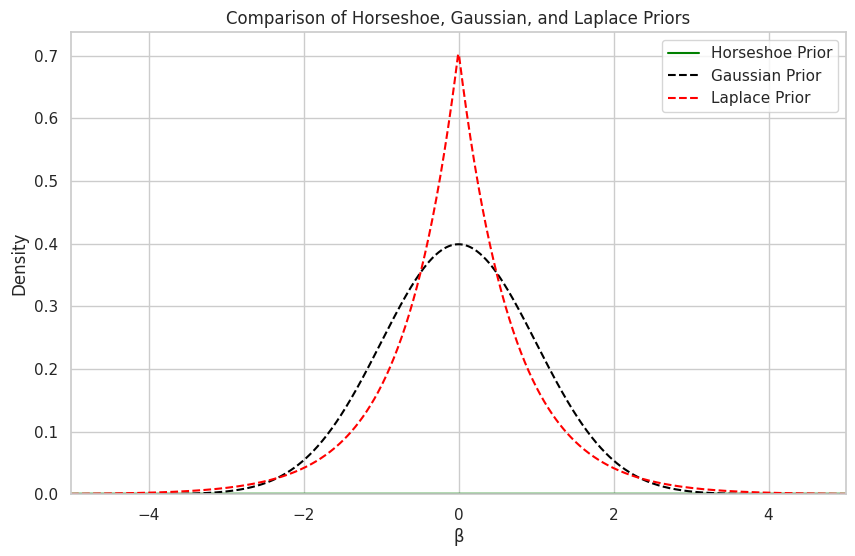

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
#import aesara.tensor as at

# Define grid
x = np.linspace(-5, 5, 1000)

# Gaussian prior (Normal(0, 1))
gaussian_pdf = (1/np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

# Laplace prior (Laplace(0, 1 / sqrt(2)) → same std as N(0, 1))
b = 1 / np.sqrt(2)
laplace_pdf = (1 / (2 * b)) * np.exp(-np.abs(x) / b)

# Sample Horseshoe Prior
rng = np.random.default_rng(42)
n_samples = 100000
tau = rng.standard_cauchy(n_samples)
tau = np.abs(tau)

lambdas = rng.standard_cauchy(n_samples)
lambdas = np.abs(lambdas)

scales = tau * lambdas
betas = rng.normal(loc=0, scale=scales)

# KDE of Horseshoe prior
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(betas, label="Horseshoe Prior", bw_adjust=0.5, color="green")
plt.plot(x, gaussian_pdf, label="Gaussian Prior", linestyle="--", color="black")
plt.plot(x, laplace_pdf, label="Laplace Prior", linestyle="--", color="red")

plt.xlim(-5, 5)
plt.title("Comparison of Horseshoe, Gaussian, and Laplace Priors")
plt.xlabel("β")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import f1_score

# --- tiny helpers (reuse yours if already defined) ---
def _sigmoid(z): return 1.0/(1.0+np.exp(-z))
def _predict_proba_safe(clf, X):
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(X)
        if proba.ndim == 1 or proba.shape[1] == 1:
            p1 = np.ravel(proba); proba = np.c_[1-p1, p1]
        return proba
    elif hasattr(clf, "decision_function"):
        z = clf.decision_function(X)
        z = np.ravel(z) if getattr(z, "ndim", 1) > 1 else z
        p1 = _sigmoid(z)
        return np.c_[1-p1, p1]
    else:
        yhat = clf.predict(X).astype(int)
        proba = np.zeros((len(yhat), 2)); proba[np.arange(len(yhat)), yhat] = 1.0
        return proba

def _strat_boot_idx(y, rng):
    classes, counts = np.unique(y, return_counts=True)
    if len(classes) < 2: return None
    idxs = np.concatenate([rng.choice(np.where(y==c)[0], size=cnt, replace=True)
                           for c, cnt in zip(classes, counts)])
    rng.shuffle(idxs); return idxs

def _bootstrap_coef_matrix(X, y, base_estimator, n_bootstraps=150, random_state=123):
    rng = np.random.RandomState(random_state)
    coefs, attempts = [], 0
    max_attempts = 5 * n_bootstraps
    while len(coefs) < n_bootstraps and attempts < max_attempts:
        attempts += 1
        idx = _strat_boot_idx(y, rng)
        if idx is None: break
        Xb, yb = X[idx], y[idx]
        if len(np.unique(yb)) < 2: continue
        try:
            bs = clone(base_estimator).fit(Xb, yb)
            beta = getattr(bs, "coef_", None)
            if beta is None: continue
            beta = np.ravel(beta)
            if not np.all(np.isfinite(beta)): continue
            coefs.append(beta)
        except Exception:
            continue
    return np.array(coefs)

def _freq_sign_entropy_on(X, y, evaluator, n_bootstraps=150, random_state=123):
    B = _bootstrap_coef_matrix(X, y, evaluator, n_bootstraps=n_bootstraps, random_state=random_state)
    if B.shape[0] < 10:  # too few successes => return NaNs
        return np.full(X.shape[1], np.nan)
    return calculate_entropies(B)  # <-- your KDE-based per-feature entropy


# --- build the objective as a closure over your data/estimators ---
def make_objective(X_train, y_train, bayes_selector_estimator, evaluator,
                   cv_splits=5, slack_low=1e-4, slack_high=1e-1,
                   bootstrap_for_entropy=150, seed=123):
    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed)
    def objective(trial):
        slack = trial.suggest_float("slack", slack_low, slack_high, log=True)
        f1s, ents = [], []
        for tr_idx, va_idx in skf.split(X_train, y_train):
            X_tr, X_va = X_train[tr_idx], X_train[va_idx]
            y_tr, y_va = y_train[tr_idx], y_train[va_idx]

            # BayCOFE selection on this fold
            sel_idx, _ = baycofe_select_features_cls(
                X_tr, y_tr,
                estimator=bayes_selector_estimator,
                slack=slack, num_iter=10, tolerance_limit=3
            )
            sel_idx = np.asarray(sel_idx, dtype=int)
            if sel_idx.size == 0:
                f1s.append(0.0); ents.append(1.0); continue

            # Fit SAME evaluator and score
            ev = clone(evaluator).fit(X_tr[:, sel_idx], y_tr)
            proba = _predict_proba_safe(ev, X_va[:, sel_idx])
            y_pred = (proba[:,1] >= 0.5).astype(int)
            f1s.append(f1_score(y_va, y_pred, average="macro"))

            # Entropy on VAL subset (bootstrap evaluator)
            ent = _freq_sign_entropy_on(X_va[:, sel_idx], y_va, evaluator=ev,
                                        n_bootstraps=bootstrap_for_entropy,
                                        random_state=trial.number + 17)
            ents.append(np.nanmean(ent))

        mean_f1  = float(np.mean(f1s))
        mean_ent = float(np.nanmean(ents))
        trial.set_user_attr("mean_f1", mean_f1)
        trial.set_user_attr("mean_entropy", mean_ent)
        # Multi-objective: minimize (-F1, Entropy)
        return -mean_f1, mean_ent
    return objective


# --- optional early-stop callback for few trials ---
def make_plateau_callback(patience=4, f1_tol=0.002, ent_tol=0.01):
    state = {"best_f1": -np.inf, "best_ent": np.inf, "stale": 0}
    def cb(study, trial):
        f1  = trial.user_attrs.get("mean_f1")
        ent = trial.user_attrs.get("mean_entropy")
        improved = False
        if f1 is not None and f1 > state["best_f1"] + f1_tol:
            state["best_f1"] = f1; improved = True
        if ent is not None and ent < state["best_ent"] - ent_tol:
            state["best_ent"] = ent; improved = True
        state["stale"] = 0 if improved else state["stale"] + 1
        if state["stale"] >= patience:
            study.stop()
    return cb


sampler = optuna.samplers.TPESampler(seed=123, n_startup_trials=3)
objective = make_objective(
    X_tr, y_tr,
    bayes_selector_estimator=bayes_logit,
    evaluator=freq_logit,
    cv_splits=5,
    slack_low=1e-4, slack_high=1e-1,
    bootstrap_for_entropy=150,  # small for CV speed
    seed=123
)

study = optuna.create_study(directions=["minimize","minimize"], sampler=sampler)
study.optimize(objective, n_trials=12, callbacks=[ make_plateau_callback() ])

[I 2025-09-30 13:29:37,738] A new study created in memory with name: no-name-8c17f45d-4382-4e9b-844a-5fd3fc660d53
[W 2025-09-30 13:29:53,526] Trial 0 failed with parameters: {'slack': 0.012285916427548801} because of the following error: UnboundLocalError("cannot access local variable 'H_last' where it is not associated with a value").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-642890922.py", line 73, in objective
    sel_idx, _ = baycofe_select_features_cls(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2130687004.py", line 923, in baycofe_select_features_cls
    return selected_idx, H_last
                         ^^^^^^
UnboundLocalError: cannot access local variable 'H_last' where it is not associated with a value
[W 2025-09-30 13:29:53,527] Trial 0 failed with value None

UnboundLocalError: cannot access local variable 'H_last' where it is not associated with a value

In [ ]:
### test corr and error of bay vs freq
sel_idx, metrics = evaluate_feature_selection_method_cls(
        baycofe_select_features_cls,  # now Bayesian version
        X_tr, y_tr, X_te, y_te,
        selector_params={'estimator': bayes_logit, 'evaluator': bayes_logit, 'slack': 0.0001})
print("BayCOFE Selected:", sel_idx)
print("Acc:", metrics["accuracy"], "LogLoss:", metrics["log_loss"], "entropy:", metrics['mean_entropy'])


BayCOFE Selected: [ 1  5  8  9 10 11 12]
Acc: 0.9707602339181286 LogLoss: 0.1183181859231244 entropy: 0.03227859305894667


In [ ]:
# BayCOFE (logistic) — you already had this
"""
sel_baycofe, metrics_baycofe = evaluate_feature_selection_method_cls(
    baycofe_select_features_cls,
    X_tr, y_tr, X_te, y_te,
    selector_params={'estimator': bayes_logit, 'slack': slack}
)
print("BayCOFE Selected:", sel_baycofe)
print("Acc:", metrics_baycofe["accuracy"], "LogLoss:", metrics_baycofe["log_loss"])
"""
# RFE (wrap estimator so it has coef_)
sel_rfe, metrics_rfe = evaluate_feature_selection_method_cls(
    rfe_select_features,
    X_tr, y_tr, X_te, y_te,
    selector_params={'estimator': bayes_logit}  # wrapper happens inside rfe_select_features
)
print("RFE Selected:", sel_rfe)
print("Acc:", metrics_rfe["accuracy"], "LogLoss:", metrics_rfe["log_loss"])

# SFS (forward)
sel_sfs, metrics_sfs = evaluate_feature_selection_method_cls(
    forward_select_features,
    X_tr, y_tr, X_te, y_te,
    selector_params={'estimator': bayes_logit}
)
print("SFS Selected:", sel_sfs)
print("Acc:", metrics_sfs["accuracy"], "LogLoss:", metrics_sfs["log_loss"])

# SBS (backward)
sel_sbs, metrics_sbs = evaluate_feature_selection_method_cls(
    sbs_select_features,
    X_tr, y_tr, X_te, y_te,
    selector_params={'estimator': bayes_logit}
)
print("SBS Selected:", sel_sbs)
print("Acc:", metrics_sbs["accuracy"], "LogLoss:", metrics_sbs["log_loss"])

# Bidirectional (SFFS)
sel_bidir, metrics_bidir = evaluate_feature_selection_method_cls(
    bidirectional_select_features,
    X_tr, y_tr, X_te, y_te,
    selector_params={'estimator': bayes_logit}
)
print("Bidirectional Selected:", sel_bidir)
print("Acc:", metrics_bidir["accuracy"], "LogLoss:", metrics_bidir["log_loss"])

RFE Selected: [0 1 2 3 4 5 6 7 8 9]
Acc: 0.6533333333333333 LogLoss: 0.6277289380382874
SFS Selected: [0 1 5 6 9]
Acc: 0.69 LogLoss: 0.6788275301195336
SBS Selected: [0 1 5 6]
Acc: 0.69 LogLoss: 0.6779116168605839
Bidirectional Selected: [0 1 5 6]
Acc: 0.69 LogLoss: 0.6779116168605839
